# **Project 1: End-to-End Pipeline to Classify News Articles**

*Tania Rajabally (UID:806153219)*


# **Question 1**

In [1]:
#imports and downloads required in this project
from google.colab import drive
import re
import numpy as np
import random
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords' )
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import NMF
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
import pandas as pd
from nltk.stem import *
from tempfile import mkdtemp
from shutil import rmtree
import joblib
from joblib import Memory
from sklearn.pipeline import Pipeline
from collections import Counter
import os
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from scipy import spatial
!pip install umap-learn
!pip install umap-learn[plot]
import umap
import umap.plot
import umap.umap_ as umap_
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=4548644fa46f021a322756ca7cd07810193e8d1b92299cdbcdff326ab3feefa9
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 10.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
#mounting the drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Reading the csv from drive and storing it in a dataframe
df=pd.read_csv('gdrive/My Drive/Winter Quarter 2024/219 - Large Scale Data Mining/Project1-ClassificationDataset.csv')
#print(df)
df.shape

(3476, 8)

In [ ]:
#Used to see the datatypes of the variables in the dataframe
df.dtypes

full_text       object
summary         object
keywords        object
publish_date    object
authors         object
url             object
leaf_label      object
root_label      object
dtype: object

Text(0.5, 0, 'Count')

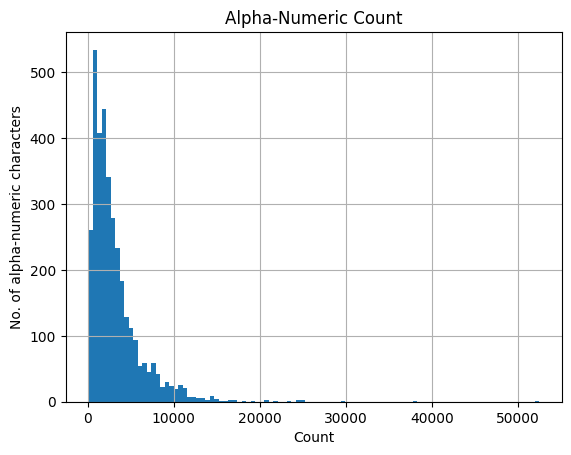

In [ ]:
#Histograms on the total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis;
df['Alpha-Numeric Count'] = df.full_text.str.len()
ax = df.hist(column='Alpha-Numeric Count', bins=100)
plt.ylabel('No. of alpha-numeric characters')
plt.xlabel('Count')

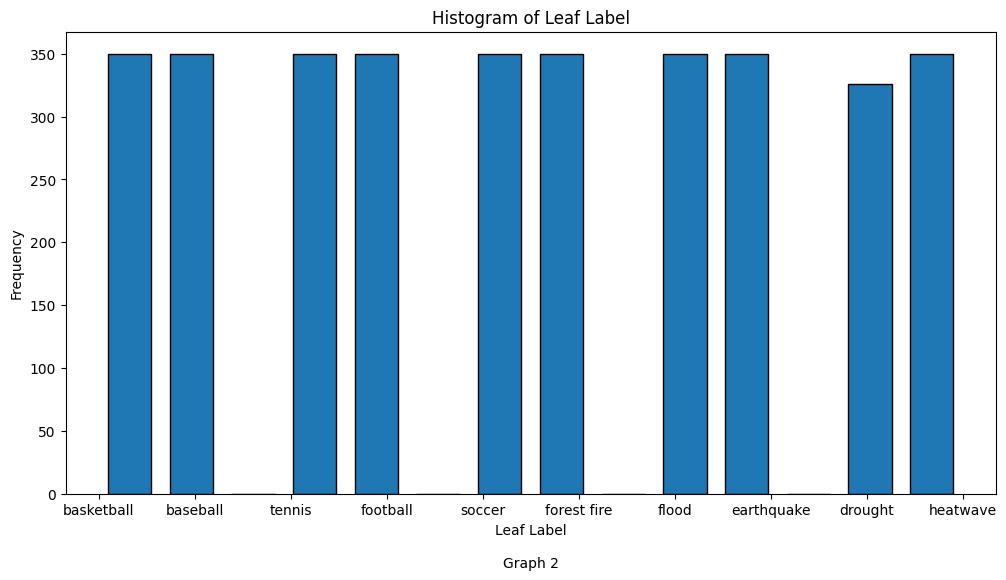

In [ ]:
#Histogram on the column leaf label – class on the x-axis;
plt.figure(figsize=(12, 6))
plt.hist(df['leaf_label'], bins='auto', edgecolor='black',rwidth=0.7)
plt.xlabel('Leaf Label')
plt.ylabel('Frequency')
plt.title('Histogram of Leaf Label')
plt.text(0.5, -0.15, "Graph 2", ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

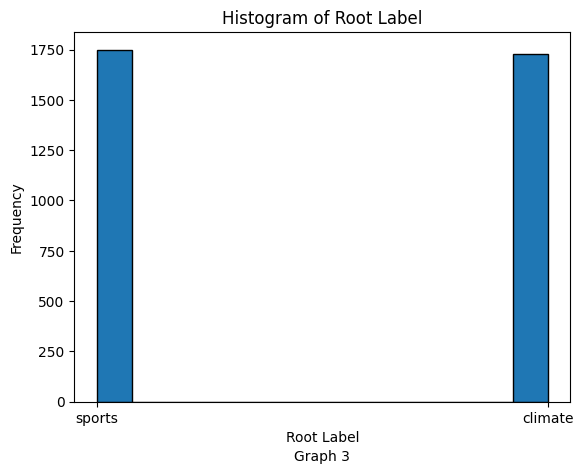

In [ ]:
#Histogram on the column root label – class on the x-axis.
plt.hist(df['root_label'], bins='auto', edgecolor='black')
plt.xlabel('Root Label')
plt.ylabel('Frequency')
plt.title('Histogram of Root Label')
plt.text(0.5, -0.15, "Graph 3", ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

QUESTION 1: Provide answers to the following questions:

• Overview: How many rows (samples) and columns (features) are present in the dataset?

> **There are 3476 rows (samples) and 8 columns (features)**





• Histograms: Plot 3 histograms on :

(a) The total number of alpha-numeric characters per
data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis;

> Graph 1 - Frequency of Alpha-Numeric Characters per Data Point above represents this histogram.


(b) The column leaf label – class on the x-axis;

> Graph 2 - Histogram of Leaf Label above represents this histogram.

(c) The column root label – class on the x-axis.

> Graph 3 - Histogram of Root Label above represents this histogram.

• Interpret Plots: Provide qualitative interpretations of the histograms.

> From the root label histogram, we can see that the data is evenly distributed i.e there are equal number of rows having root label as sports and equal number of rows having root label as climate. Even for the leaf labels, it is almost evenly distributed. Only drought has a little lower data as compared to the rest. But, all the other leaf labels have evenly distributed data. This even distribution is desired as it prevents the model from overfitting on classes that have more samples than the rest.


# **Question 2**

In [4]:
#setting the random seed as follows to ensure consistency
np.random.seed(42)
random.seed(42)

In [5]:
#Splitting intro train and test data
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)
train.head()

,full_text,root_label
2677,'While the four-day Aftershock's economic impa...,climate
1204,'CBS Essentials is created independently of th...,sports
2955,'Moderate-to-severe drought will likely contin...,climate
2266,"'Colleen Flood, the longtime co-owner of The F...",climate
611,'WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE. Y...,sports


In [ ]:
#Finding the shape of the traiing data
train.shape

(2780, 2)

In [ ]:
test.head()

,full_text,root_label
2069,"'A small patch of snow on the ground in Douai,...",climate
1425,"'Antonio Zago, of Brazil, puts on a jersey dur...",sports
309,'NEW YORK >> The Las Vegas Aces became the fir...,sports
2270,'Christian Abraham/Hearst Connecticut Media\n\...,climate
3037,'The City of Watertown is currently under a wa...,climate


In [ ]:
#Finding the shape of the test data
test.shape

(696, 2)

QUESTION 2: Report the number of training and testing samples.



 > There are 2780 rows in the training samples


> There are 696 rows in the testing samples







# **Question 3**

In [6]:
#Used to clean each data sample
def clean(text):
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
    texter = ""
  return texter

In [7]:
#Adding a new column clean data in the training dataset
train['clean_data'] = [clean(i) for i in train['full_text']]
train.head()

,full_text,root_label,clean_data
2677,'While the four-day Aftershock's economic impa...,climate,'While the four-day Aftershock's economic impa...
1204,'CBS Essentials is created independently of th...,sports,'CBS Essentials is created independently of th...
2955,'Moderate-to-severe drought will likely contin...,climate,'Moderate-to-severe drought will likely contin...
2266,"'Colleen Flood, the longtime co-owner of The F...",climate,"'Colleen Flood, the longtime co-owner of The F..."
611,'WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE. Y...,sports,'WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE. Y...


In [8]:
#Adding a new column clean data in the testing dataset
test['clean_data'] = [clean(i) for i in test['full_text']]
test.head()

,full_text,root_label,clean_data
2069,"'A small patch of snow on the ground in Douai,...",climate,"'A small patch of snow on the ground in Douai,..."
1425,"'Antonio Zago, of Brazil, puts on a jersey dur...",sports,"'Antonio Zago, of Brazil, puts on a jersey dur..."
309,'NEW YORK >> The Las Vegas Aces became the fir...,sports,'NEW YORK >> The Las Vegas Aces became the fir...
2270,'Christian Abraham/Hearst Connecticut Media\n\...,climate,'Christian Abraham/Hearst Connecticut Media Ov...
3037,'The City of Watertown is currently under a wa...,climate,'The City of Watertown is currently under a wa...


In [9]:
#getting rid of digits and punctuations
train['clean_data'] = [re.sub(r'[^\w\s\d]', '', i) for i in train['clean_data']]
train['clean_data'] = [re.sub("\S*\d\S*", "", i).strip() for i in train['clean_data']]
train.head()
train.shape

(2780, 3)

In [10]:
#getting rid of digits and punctuations
test['clean_data'] = [re.sub(r'[^\w\s\d]', '', i) for i in test['clean_data']]
test['clean_data'] = [re.sub("\S*\d\S*", "", i).strip() for i in test['clean_data']]
test.head()

,full_text,root_label,clean_data
2069,"'A small patch of snow on the ground in Douai,...",climate,A small patch of snow on the ground in Douai i...
1425,"'Antonio Zago, of Brazil, puts on a jersey dur...",sports,Antonio Zago of Brazil puts on a jersey during...
309,'NEW YORK >> The Las Vegas Aces became the fir...,sports,NEW YORK The Las Vegas Aces became the first ...
2270,'Christian Abraham/Hearst Connecticut Media\n\...,climate,Christian AbrahamHearst Connecticut Media Over...
3037,'The City of Watertown is currently under a wa...,climate,The City of Watertown is currently under a wat...


In [11]:
lemmatizer = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()
stop_words = text.ENGLISH_STOP_WORDS
stop_words_english = stopwords.words('english')
#making a combined set of punctuations and stopwords
combined_stopwords = set.union(set(stop_words_english),set(punctuation),set(stop_words))

In [12]:
def pennTreebankToWordnet(penntag):
    #Converts Penn Treebank tags to WordNet.
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [lemmatizer.lemmatize(word.lower(), pos=pennTreebankToWordnet(tag))
            for word, tag in pos_tag(list_word)]

def stem_rmv_punc(doc): # this should have been at the sentence-level because the pos-tag performs best at sentence-level
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

#Using min_df=3
count_vectorizer = CountVectorizer(min_df=3, analyzer=stem_rmv_punc)

In [13]:
#fitting the vectorizer to the data and transforming the raw text data into a document-term matrix.
X_train_counts = count_vectorizer.fit_transform(train['clean_data'])
X_train_counts.shape

(2780, 13729)

In [14]:
X_test_counts = count_vectorizer.transform(test['clean_data'])
X_test_counts.shape

(696, 13729)

In [15]:
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

(2780, 13729)


In [16]:
X_test_tfidf = tfidf.fit_transform(X_test_counts)
print(X_test_tfidf.shape)

(696, 13729)


In [ ]:
print(X_test_tfidf)

  (0, 13654)	0.04752650590445146
  (0, 13399)	0.06686372331753054
  (0, 13355)	0.045266678778271625
  (0, 13340)	0.21184502949987313
  (0, 13277)	0.03688573904755693
  (0, 12970)	0.0624411658959558
  (0, 12965)	0.04558680321219656
  (0, 12852)	0.046856103617583224
  (0, 12832)	0.2615871601617954
  (0, 12683)	0.03945844700291285
  (0, 12657)	0.03893195987990279
  (0, 12603)	0.02536634980964024
  (0, 12481)	0.040143982638174244
  (0, 12470)	0.09371220723516645
  (0, 12404)	0.08460960591545776
  (0, 12338)	0.01632644672544876
  (0, 12144)	0.08950142922296977
  (0, 12138)	0.07568104752732707
  (0, 12132)	0.11931076797960968
  (0, 12117)	0.0790380421031558
  (0, 12056)	0.03193913682185134
  (0, 12027)	0.06636750496921381
  (0, 11992)	0.057494563670250215
  (0, 11896)	0.0624411658959558
  (0, 11837)	0.035796553585286106
  :	:
  (695, 4605)	0.049575972318561395
  (695, 4395)	0.08356094362944586
  (695, 4084)	0.05623078498435636
  (695, 3753)	0.07597031117287446
  (695, 3097)	0.078061212070821

QUESTION 3:

Use the following specs to extract features from the textual data:


*   Before doing anything, please clean each data sample using the code block provided above.
This function helps remove many but not all HTML artefacts from the crawler’s output. You
can also build your own cleaning module if you find this function to be ineffective.
*   Use the “english” stopwords of the CountVectorizer
*   Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
*  Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos tag
* Use min df=3

Please answer the following questions:

• What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?

> Both lemmatization and stemming are techniques used to reduce words to their base or root form.

> Pros of lemmatization:
*   It produces valid words. The base words can be found in the dictionary and are hence valid words.
*   The lemmatized words are more interpretable and maintain the semantic meaning better than stemming.

> Cons of lemmatization:
*   It is computationally expensive since it involves dictionary lookups and morphological analysis.
*   Lemmatization may not be able to deal with irregular forms.

> Pros of stemming:
*   Stemming is computationally efficient and is faster than lemmatization since it involves simpler rule based truncation.
*   Stemming reduces words to their base or root form by removing common prefixes or suffixes, helping to group related words.

> Cons of stemming:
*   Stemming may produce words that do not exist.
*   It might be overly aggressive in its truncation, leading to loss of information.

>  How these processes affect dictionary size:
* Lemmatization: lemmatization reduces the dictionary size compared to the original text. This happens because words are mapped to their base or dictionary forms, eliminating variations.
* Stemming: It can also reduce the dictionary size, but it may be less effective in eliminating variations compared to lemmatization. Stemmed words might still have variations that are not fully captured.

> Lemmatization is often preferred when the preservation of valid words and semantic meaning is crucial, even at the cost of computational complexity. Stemming, on the other hand, is faster and can be suitable for applications where computational efficiency is a priority, and minor variations are acceptable.


• min df means minimum document frequency. How does varying min df change the TF-IDF matrix?

> min_df helps control the vocabulary size. It excludes terms that appear in a very small number of documents. Hence, changing the min_df parameter can have a significant impact on the resulting TF-IDF matrix. If we have a higher min_df, the words which appear in very few documents will be eliminated from the vocabulary. Hence, the vocabulary size will be smaller and the matrix will focus on the terms that occur frequently. If we have a smaller min_df, we will include the terms that do not occur frequently and hence will have a larger vocabulary size. The matrix may include more specific terms that are unique to certain documents, potentially capturing more nuanced information

• Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing?

Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure.

> Generally stopwords, punctuations and numbers are removed before lemmatization. Stopwords do not carry significant meaning. Hence, removing them early in the preprocessing pipeline helps to reduce noise and focus on the more meaningful terms. Punctuation marks usually do not contribute to the meaning of words, and removing them early in the process helps to simplify the text. If numbers are not crucial to your analysis, removing them early can help streamline the text.

• Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×103
. This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.


> TF-IDF-processed train data shape : (2780, 13729)

> TF-IDF-processed train data shape : (696, 13729)




# **Question 4**

In [ ]:
#Trying on random sentences to check if it is predicting properly
clf = MultinomialNB().fit(X_train_tfidf, train['root_label'])
docs_new = ['He is playing football today', 'Today is sunny']

X_new_counts = count_vectorizer.transform(docs_new)
X_new_tfidf = tfidf.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, category))

'He is playing football today' => sports
'Today is sunny' => climate


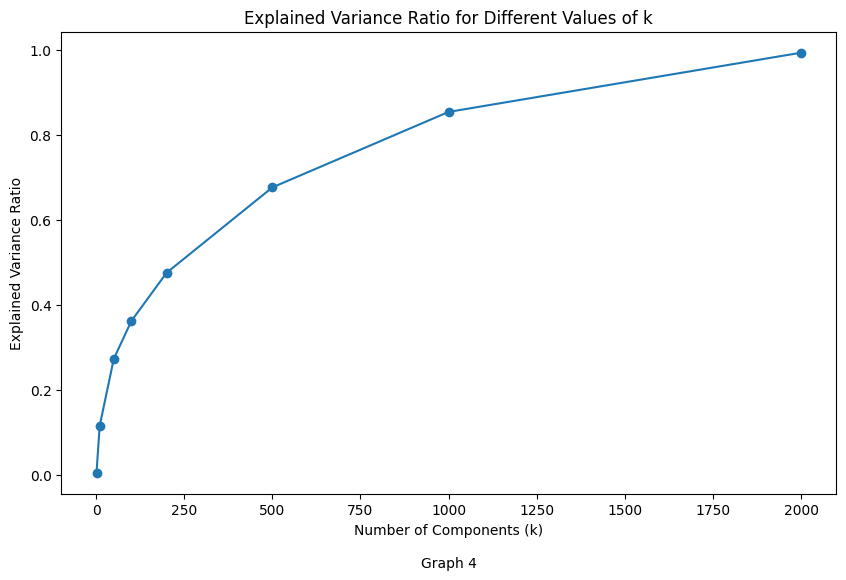

In [ ]:
# Values of k (number of components)
k_values = [1, 10, 50, 100, 200, 500, 1000, 2000]

# Initialize lists to store explained variance ratios
explained_var_ratios = []

# Iterate through each value of k
for k in k_values:
    lsi_model = TruncatedSVD(n_components=k)
    lsi_model.fit(X_train_tfidf)
    explained_var_ratios.append(np.sum(lsi_model.explained_variance_ratio_))

# Plotting the explained variance ratios
plt.figure(figsize=(10, 6))
plt.plot(k_values, explained_var_ratios, marker='o')
plt.title('Explained Variance Ratio for Different Values of k')
plt.xlabel('Number of Components (k)')
plt.ylabel('Explained Variance Ratio')
plt.text(0.5, -0.15, "Graph 4", ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [ ]:
#Using LSI with k=50
LSI = TruncatedSVD(n_components=50, random_state=42)
X_train_LSI = LSI.fit_transform(X_train_tfidf) # performing LSI on the tfidf train matrix
X_test_LSI = LSI.transform(X_test_tfidf) # performing LSI on the tfidf test matrix
U,Sig,VT = randomized_svd(X_train_tfidf,n_components=50,random_state=42) # obtaining the left singular matrix, singular values and right singular matrix
Sig = np.diag(Sig)
print("Error for LSI: ", np.sum(np.array(X_train_tfidf - U.dot(Sig).dot(VT))**2))

#Using NMF with k=50
nmf = NMF(n_components=50, init='random', random_state=42)
X_train_NMF = nmf.fit_transform(X_train_tfidf) # performing NMF on the tfidf train matrix
X_test_NMF = nmf.transform(X_test_tfidf) # performing NMF on the tfidf test matrix
H = nmf.components_
print("Error for NMF: ", np.sum(np.array(X_train_tfidf - X_train_NMF.dot(H))**2))

Error for LSI:  1954.3696979505175
Error for NMF:  1985.128192630896


QUESTION 4: Reduce the dimensionality of the data using the methods above:

* Plot the explained variance ratio across multiple different k = [1, 10, 50, 100, 200, 500, 1000, 2000] for LSI and for the next few sections choose k = 50. What does the explained variance ratio plot look like? What does the plot’s concavity suggest?


> Refer to figure 4 - Explained Variance Ratio for Different Values of k above to see how the explained variance ratio plot looks like.

> The explained variance ratio changes with increasing k. If the plot shows diminishing returns in terms of explained variance ratio as k increases, it suggests that adding more components beyond a certain point contributes less to explaining the variance in the data. The concavity may indicate a point of diminishing returns in terms of capturing additional information with more components.

* With k = 50 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF – they both should use the same k = 50. Which one is larger, the ∥X − WH∥2F in NMF or the X − UkΣkVTk 2F in LSI and why?


> Error for LSI:  1954.3696979505175

> Error for NMF:  1985.128192630896

> The error for NMF is larger. NMF has a larger reconstruction residual error. This depends on how well the factorization captures the original data structure. A higher MSE indicates a larger difference between the original and reconstructed matrices. It depends on the specific characteristics of the data and how well each method captures its underlying structure. NMF has more constraints than LSI. The added constraints are W≥0 and H≥0. This reduces the degrees of freedom and makes the search space more restrictive. Whereas, LSI has a much larger search space to explore. It has more freedom to find the best vectors that minimize the error and the best vectors can include negative elements. This is not possible in NMF.




# **Question 5**

In [ ]:
#Function to plot roc curve - illustrates the diagnostic ability of a binary classification model across different threshold settings.
def plot_roc_curve(y_test,decision_function,name=""):
    fpr = dict();tpr = dict();roc_auc = dict()
    fpr, tpr, thresholds = roc_curve(y_test, decision_function)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate');
    plt.title('%s ROC curve' % name);plt.legend(loc="lower right")

#Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#Printing the accuracy, recall, precision and F-1 Score
def print_metrics(y_test,y_pred,name="",average='binary'):
    print("Accuracy score for %s: %f" %(name,accuracy_score(y_test,y_pred)))
    print("Recall score for %s: %f" % (name,recall_score(y_test,y_pred,average=average)))
    print("Precision score for %s: %f" % (name,precision_score(y_test,y_pred,average=average)))
    print("F-1 score for %s: %f" % (name,f1_score(y_test,y_pred,average=average)))

In [ ]:
#Training two SVMs - Hard-margin (C=1000) and Soft-margin (C=0.0001)
hardSVM = LinearSVC(C=1000,random_state=42)
softSVM = LinearSVC(C=0.0001,random_state=42)

In [ ]:
#Creating a new column with labels (Sports=0 and Climate=1)
train['label'] = np.where(train['root_label'].eq('sports'), 0, 1)
test['label'] = np.where(test['root_label'].eq('sports'), 0, 1)

In [ ]:
y_pred_hardSVM = hardSVM.fit(X_train_LSI,train.label).predict(X_test_LSI) # predicting labels for hard margin SVM
y_pred_softSVM = softSVM.fit(X_train_LSI,train.label).predict(X_test_LSI) # predicting labels for soft margin SVM
print(y_pred_hardSVM)

[1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0
 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0
 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 1 1
 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1
 1 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0
 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1
 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1
 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0
 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1
 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1
 0 0 1 0 0 0 1 1 0 1 1 0 

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
print(test.label)

2069    1
1425    0
309     0
2270    1
3037    1
       ..
547     0
776     0
2873    1
2236    1
568     0
Name: label, Length: 696, dtype: int64


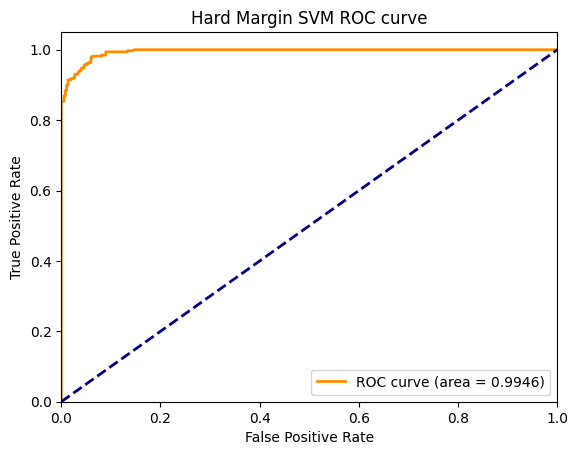

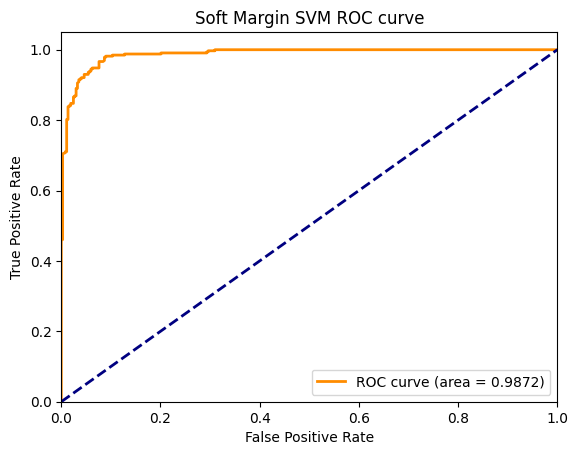

In [ ]:
#Plotting the ROC Curve for hard margin SVM and soft margin SVM
plot_roc_curve(test.label,hardSVM.decision_function(X_test_LSI),name="Hard Margin SVM") # Hard SVM ROC curve
plot_roc_curve(test.label,softSVM.decision_function(X_test_LSI),name="Soft Margin SVM") # Soft SVM ROC curve

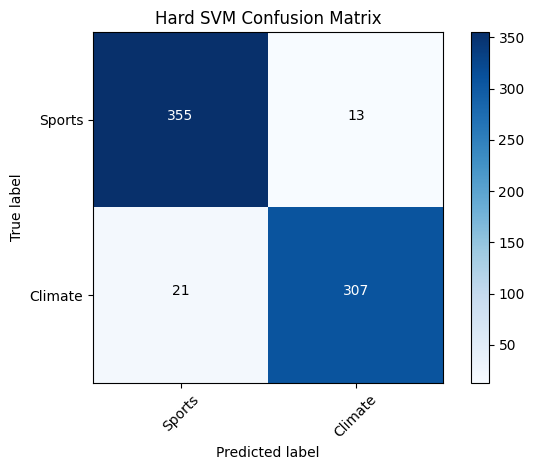

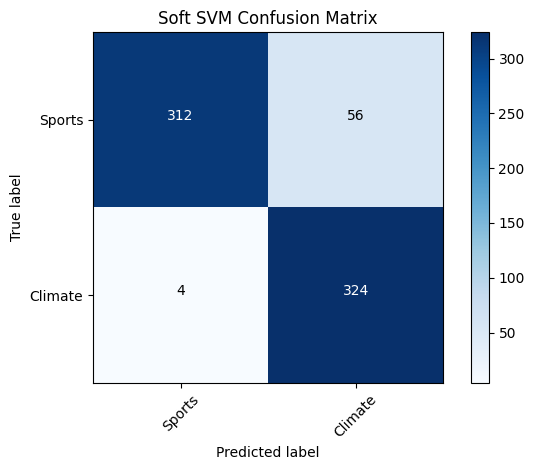

In [ ]:
#Making confusion matrix for hard margin SVM and soft margin SVM
class_names = ['Sports', 'Climate']
hardSVM_cm = confusion_matrix(test.label,y_pred_hardSVM) # Hard SVM Confusion matrix
plt.figure();
plot_confusion_matrix(hardSVM_cm, classes=class_names, title='Hard SVM Confusion Matrix')
softSVM_cm = confusion_matrix(test.label,y_pred_softSVM) # Soft SVM Confusion matrix
plt.figure();
plot_confusion_matrix(softSVM_cm, classes=class_names, title='Soft SVM Confusion Matrix')

In [ ]:
#Printing accuracy, recall, precision and F-1 score for both hard margin SVM and soft margin SVM
print_metrics(test.label,y_pred_hardSVM,name="Hard Margin SVM")
print_metrics(test.label,y_pred_softSVM,name="Soft Margin SVM")

Accuracy score for Hard Margin SVM: 0.951149
Recall score for Hard Margin SVM: 0.935976
Precision score for Hard Margin SVM: 0.959375
F-1 score for Hard Margin SVM: 0.947531
Accuracy score for Soft Margin SVM: 0.913793
Recall score for Soft Margin SVM: 0.987805
Precision score for Soft Margin SVM: 0.852632
F-1 score for Soft Margin SVM: 0.915254


In [ ]:
#Trying now for c=100000
newSVM = LinearSVC(C=100000,random_state=42)
y_pred_newSVM = newSVM.fit(X_train_LSI,train.label).predict(X_test_LSI) # predicting labels for new SVM with C=100000

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


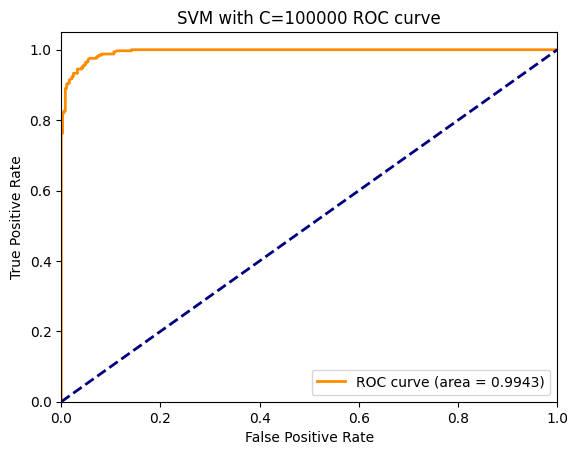

In [ ]:
plot_roc_curve(test.label,newSVM.decision_function(X_test_LSI),name="SVM with C=100000") #SVM with C=100000 ROC curve

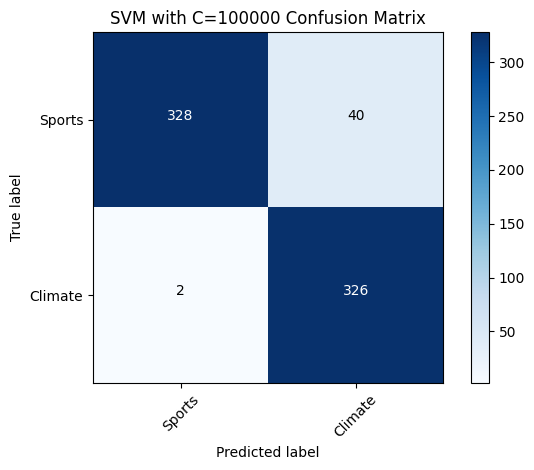

In [ ]:
newSVM_cm = confusion_matrix(test.label,y_pred_newSVM) # SVM with C=100000 Confusion matrix
plt.figure();
plot_confusion_matrix(newSVM_cm, classes=class_names, title='SVM with C=100000 Confusion Matrix')

In [ ]:
#Printing accuracy, recall, precision and F-1 score for SVM with C=100000
print_metrics(test.label,y_pred_newSVM,name="SVM with C=100000")

Accuracy score for SVM with C=100000: 0.939655
Recall score for SVM with C=100000: 0.993902
Precision score for SVM with C=100000: 0.890710
F-1 score for SVM with C=100000: 0.939481


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Grid search results for SVM:  {'mean_fit_time': array([0.00733256, 0.00892491, 0.00991282, 0.01434374, 0.07238541,
       0.14794092, 0.14960084, 0.12339439, 0.12209148, 0.12201819]), 'std_fit_time': array([0.00065433, 0.00018499, 0.00065197, 0.00021962, 0.00898113,
       0.02774232, 0.03685797, 0.00534694, 0.00968482, 0.00862843]), 'mean_score_time': array([0.0013639 , 0.0011673 , 0.00110435, 0.00110564, 0.00129967,
       0.00333529, 0.00336113, 0.00271659, 0.00146308, 0.00180697]), 'std_score_time': array([4.52595047e-04, 9.91927884e-05, 1.61822823e-05, 1.14516392e-05,
       8.87642840e-05, 1.70318273e-03, 2.12527460e-03, 1.43476707e-03,
       4.73464963e-05, 5.87407584e-04]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000,
                   1000000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {

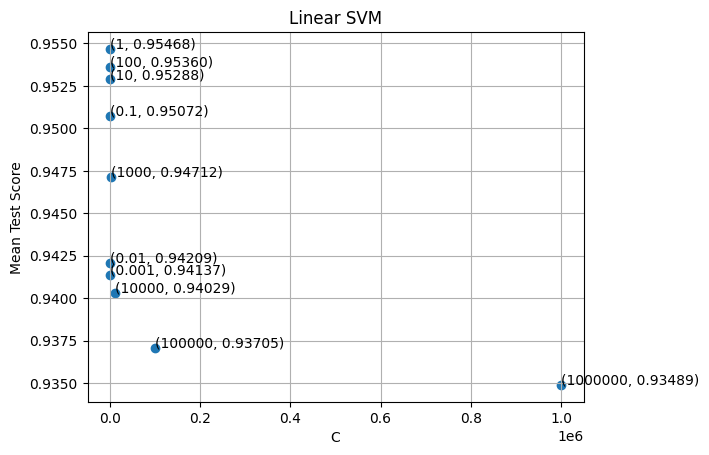

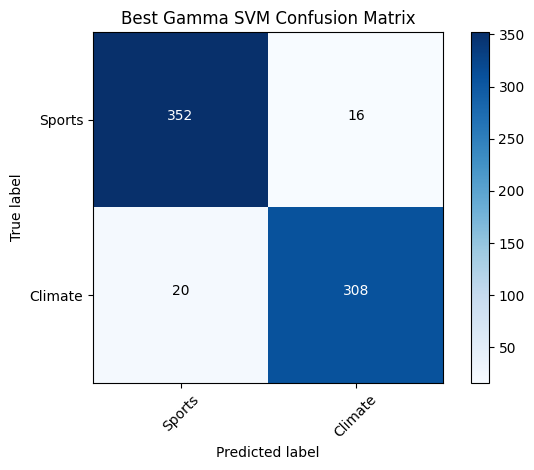

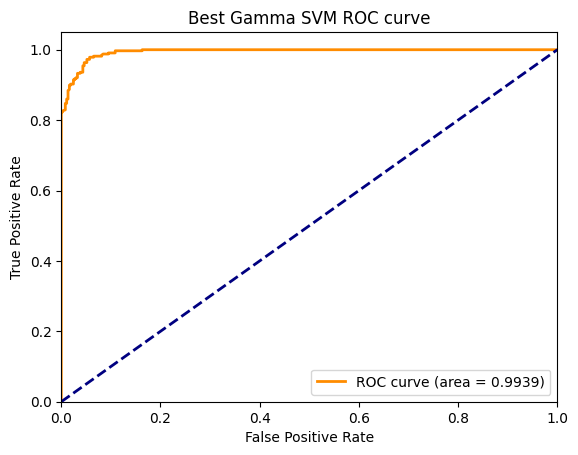

In [ ]:
svc = LinearSVC(random_state=42)
params = {'C':[0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
#cv=5 implies 5 fold cross validation
classifier = GridSearchCV(svc,params,cv=5,scoring='accuracy') # Finding the best gamma using cross validation
classifier.fit(X_train_LSI,train.label)

#Taking values in the range provided in the question
x = [0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]
y = classifier.cv_results_['mean_test_score']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):
    ax.annotate('(%s, %.5f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C');
plt.ylabel('Mean Test Score');
plt.title("Linear SVM")
plt.grid()

y_pred_cv = classifier.best_estimator_.predict(X_test_LSI)
best_gamma_for_svm = classifier.best_estimator_.C

print("Grid search results for SVM: ", classifier.cv_results_)
print("Best estimator for SVM: ", classifier.best_estimator_)
print("Best parameters for SVM: ", classifier.best_params_)
print("Best score for SVM: ", classifier.best_score_)
print("Best Gamma for SVM: ", best_gamma_for_svm)
print_metrics(test.label,y_pred_cv,name="Best Gamma SVM")

cv_cm = confusion_matrix(test.label,y_pred_cv) # Best Gamma SVM confusion matrix
plt.figure();
plot_confusion_matrix(cv_cm, classes=class_names, title='Best Gamma SVM Confusion Matrix')

plot_roc_curve(test.label,classifier.best_estimator_.decision_function(X_test_LSI),name="Best Gamma SVM") # Best Gamma SVM ROC curve

QUESTION 5: Compare and contrast hard-margin and soft-margin linear SVMs:

* Train two linear SVMs:

> – Train one SVM with γ = 1000 (hard margin), another with γ = 0.0001 (soft margin).

>  – Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?

>> Please refer to the graphs above for the ROC Curve, confusion matrix and metrics for SVMs with C=0.001,1000,100000

>> From C=0.001 (soft-margin SVM) and C=1000 (hard-margin SVM), hard-margin SVM performs better. Hard-margin SVM has a higher accuracy score which means it correctly classifies a higher proportion of instances. It has a higher precision score which means it has a higher proportion of true positive predictions among instances predicted as positive. Hard-margin SVM has a higher F1-score as well. We can see that soft margin SVM under fits the data since it gives more scope for misclassification. For y=100000, it overfits the data and the accuracy drops. For hard margin SVM, it neither underfits nor overfits the data and hence that is the best choice.

> – What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.

>> We can see that soft margin SVM under fits the data since it gives more scope for misclassification. For y=100000, it overfits the data and the accuracy drops. Soft margin SVM has a low precision and hence it is likely that it is underfitting the data. Low precision indicates a high false positive rate.

> ∗ Does the ROC curve reflect the performance of the soft-margin SVM? Why?

>> The soft margin SVM under fits the data. This is supported by the top left region of the ROC curve shown above. The ROC curve does not look competitive as the turn at the top left corner shows that it is underfitting the data and reflects the conclusion drawn.

* Use cross-validation to choose γ (use average validation 3 accuracy to compare): Using a 5-fold cross-validation, find the best value of the parameter γ in the range {10k| − 3 ≤ k ≤ 6, k ∈ Z}. Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM.

> The best value of y was found to be 1.

> Best estimator for SVM:  LinearSVC(C=1, random_state=42)

>Best parameters for SVM:  {'C': 1}

>Best score for SVM:  0.9546762589928057

>Best Gamma for SVM:  1

>Accuracy score for Best Gamma SVM: 0.948276

>Recall score for Best Gamma SVM: 0.939024

>Precision score for Best Gamma SVM: 0.950617

>F-1 score for Best Gamma SVM: 0.944785

>Refer to the figures above for confusion matrix and ROC curve.


# **Question 6**

In [ ]:
#Logistic Regression without regularization
clf = LogisticRegression(C=10**10,random_state=42)
y_pred_lr = clf.fit(X_train_LSI,train.label).predict(X_test_LSI)
#Finding the accuracy, precision, recall and F-1 score for logistic regression without regularization
print_metrics(test.label,y_pred_lr,name="Logistic Regression")

Accuracy score for Logistic Regression: 0.959770
Recall score for Logistic Regression: 0.960366
Precision score for Logistic Regression: 0.954545
F-1 score for Logistic Regression: 0.957447


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


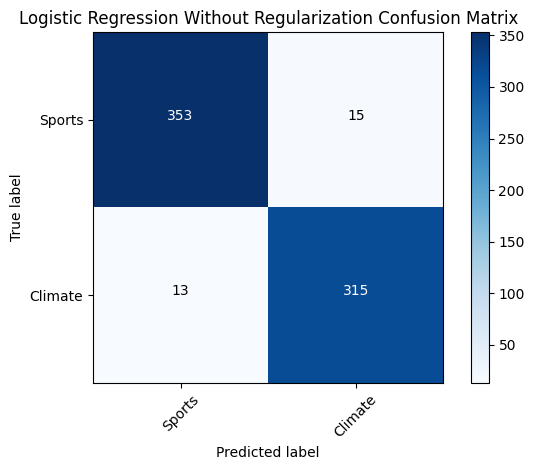

In [ ]:
#Finding the confusion matrix for logistic regression without regularization
cmx = confusion_matrix(test.label,y_pred_lr)
plt.figure();
plot_confusion_matrix(cmx, classes=class_names, title='Logistic Regression Without Regularization Confusion Matrix')

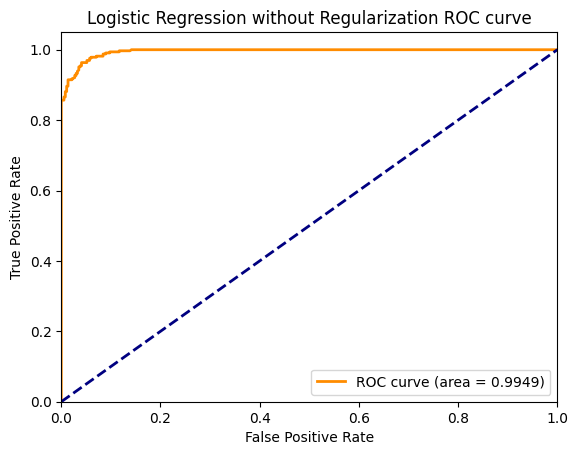

In [ ]:
#Plotting the ROC Curve for Logistic Regression without Regularization
plot_roc_curve(test.label,clf.decision_function(X_test_LSI),name="Logistic Regression without Regularization")

In [ ]:
#Logistic Regression with L1 regularization
parameters = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
logisticRegression_l1 = LogisticRegression(penalty='l1',random_state=42,solver='liblinear') # logistic regression with L1 regularization
classifier_l1 = GridSearchCV(logisticRegression_l1,parameters,cv=5,scoring='accuracy') # grid search for best gamma for L1 regularization
y_pred_l1 = classifier_l1.fit(X_train_LSI,train.label).best_estimator_.predict(X_test_LSI)
best_l1_gamma = classifier_l1.best_estimator_.C

Logistic Regression with L1 regularization - Grid search results:  {'mean_fit_time': array([0.00510612, 0.0049355 , 0.00546417, 0.00493045, 0.00866194,
       0.02145677, 0.05627956, 0.09926753, 0.10003505, 0.10796313,
       0.10241938]), 'std_fit_time': array([2.72209148e-04, 1.37475138e-04, 8.58776025e-04, 5.94779384e-05,
       1.57433144e-04, 3.51564857e-03, 5.71272673e-03, 1.33803729e-02,
       1.09555619e-02, 1.34255552e-02, 1.38129267e-02]), 'mean_score_time': array([0.00215998, 0.00109282, 0.00108972, 0.00110788, 0.00110364,
       0.00140967, 0.00129957, 0.00156698, 0.00142365, 0.00146747,
       0.00159702]), 'std_score_time': array([1.51531871e-03, 1.16816345e-05, 9.32164813e-06, 2.56325587e-05,
       5.83419568e-06, 5.67377664e-04, 1.06348306e-04, 2.31487620e-05,
       5.15984077e-05, 6.93248092e-05, 3.16050949e-04]), 'param_C': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                   10000, 100000],
             mask=[False, False, False

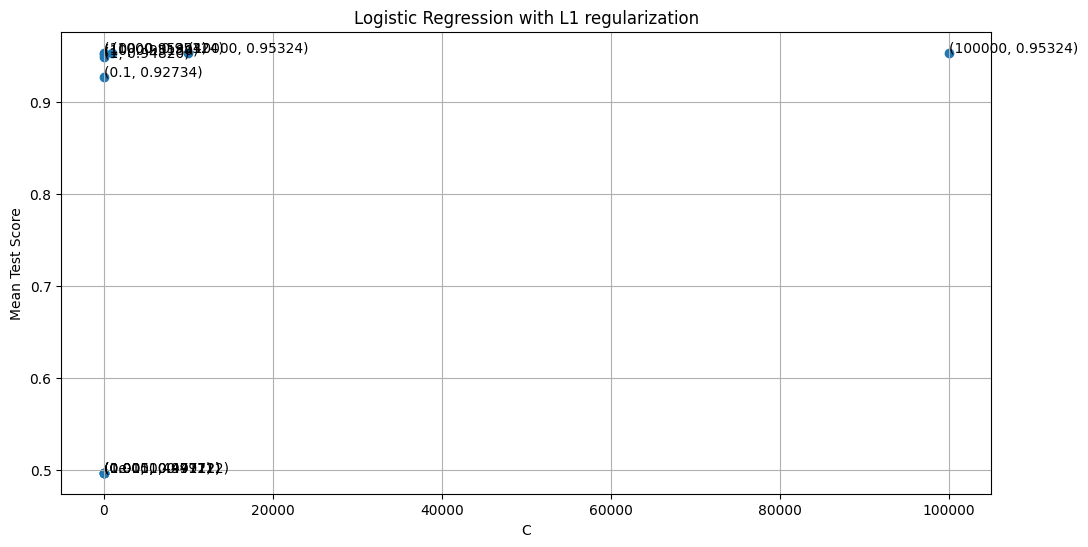

In [ ]:
#Plotting the graph for logistic regression with L1 regularization and finding the optimal regularizzation strength in the given range
x = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
y = classifier_l1.cv_results_['mean_test_score']
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):
    ax.annotate('(%s, %.5f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C'); plt.ylabel('Mean Test Score'); plt.title("Logistic Regression with L1 regularization")
plt.grid()

print("Logistic Regression with L1 regularization - Grid search results: ", classifier_l1.cv_results_)
print("Logistic Regression with L1 regularization - Best estimator: ", classifier_l1.best_estimator_)
print("Logistic Regression with L1 regularization - Best parameters: ", classifier_l1.best_params_)
print("Logistic Regression with L1 regularization - Best score: ", classifier_l1.best_score_)
print("Logistic Regression with L1 regularization - Best Gamma: ", best_l1_gamma)
print("Logistic Regression with L1 regularization - Coefficients learned: ", classifier_l1.best_estimator_.coef_)
print_metrics(test.label,y_pred_l1,name="Logistic Regression with l-1 regularization")


In [ ]:
#Logistic Regression with L2 regularization
logisticRegression_l2 = LogisticRegression(penalty='l2',random_state=42) # logistic regression with L2 regularization
classifier_l2 = GridSearchCV(logisticRegression_l2,parameters,cv=5,scoring='accuracy') # grid search for best gamma for L2 regularization
y_pred_l2 = classifier_l2.fit(X_train_LSI,train.label).best_estimator_.predict(X_test_LSI)
best_l2_gamma = classifier_l2.best_estimator_.C

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression with L2 regularization - Grid Search Results:  {'mean_fit_time': array([0.00831156, 0.00782027, 0.00623531, 0.00884838, 0.01035132,
       0.01733603, 0.03361173, 0.04963717, 0.05065155, 0.05496168,
       0.05826564]), 'std_fit_time': array([0.00065777, 0.00124452, 0.00019063, 0.00388572, 0.00050818,
       0.00113936, 0.01232351, 0.00464525, 0.00305883, 0.00676087,
       0.00806464]), 'mean_score_time': array([0.00129418, 0.0012598 , 0.00113473, 0.00125942, 0.00133395,
       0.00134768, 0.00214248, 0.00237508, 0.0019403 , 0.00182261,
       0.0014163 ]), 'std_score_time': array([5.36358933e-05, 5.07729704e-05, 2.65601293e-05, 7.84669701e-05,
       8.26350678e-05, 4.29213308e-05, 1.43278599e-03, 1.34909211e-03,
       2.65230458e-04, 3.72726792e-04, 3.76105139e-05]), 'param_C': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                   10000, 100000],
             mask=[False, False, False, False, False, False, False, False,
       

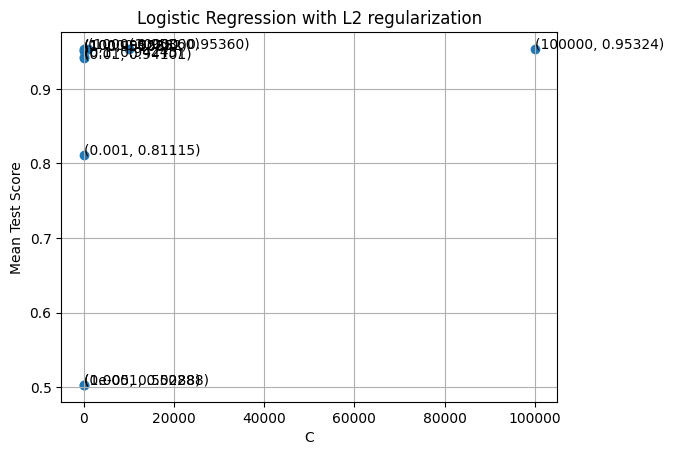

In [ ]:
#Plotting the graph for logistic regression with L2 regularization
x = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
y = classifier_l2.cv_results_['mean_test_score']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):
    ax.annotate('(%s, %.5f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C'); plt.ylabel('Mean Test Score'); plt.title("Logistic Regression with L2 regularization")
plt.grid()


print("Logistic Regression with L2 regularization - Grid Search Results: ", classifier_l2.cv_results_)
print("Logistic Regression with L2 regularization - Best estimator: ", classifier_l2.best_estimator_)
print("Logistic Regression with L2 regularization - Best parameters: ", classifier_l2.best_params_)
print("Logistic Regression with L2 regularization - Best score: ", classifier_l2.best_score_)
print("Logistic Regression with L2 regularization - Best Gamma: ", best_l2_gamma)
print("Logistic Regression with L2 regularization - Coefficients learned: ", classifier_l2.best_estimator_.coef_)
print_metrics(test.label,y_pred_l2,name="Logistic Regression with L2 regularization")

QUESTION 6: Evaluate a logistic classifier:

* Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear model.LogisticRegression); plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this classifier on the testing set.

> Refer to the figures above for the confusion matrix and ROC curve for Logistic Regression without regularization.

> Accuracy score for Logistic Regression: 0.959770

> Recall score for Logistic Regression: 0.960366

> Precision score for Logistic Regression: 0.954545

> F-1 score for Logistic Regression: 0.957447

* Find the optimal regularization coefficient:

> – Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the optimal regularization strength in the range {10k|−5 ≤ k ≤ 5, k ∈ Z} for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.

>> For L1 regularization - the optimal regularization strength is 100.

>> For L2 regularization - the optimal regularization strength is 1000.

> – Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.

>> For Logistic Regression without regularization

>>> Accuracy score for Logistic Regression: 0.959770

>>> Recall score for Logistic Regression: 0.960366

>>> Precision score for Logistic Regression: 0.954545

>>>F-1 score for Logistic Regression: 0.957447

>> For Logistic Regression with L1 Regularization

>>> Accuracy score for Logistic Regression with l-1 regularization: 0.958333

>>>Recall score for Logistic Regression with l-1 regularization: 0.960366

>>>Precision score for Logistic Regression with l-1 regularization: 0.951662

>>>F-1 score for Logistic Regression with l-1 regularization: 0.955994

>> For Logistic Regression with L2 Regularization

>>> Accuracy score for Logistic Regression with L2 regularization: 0.958333

>>>Recall score for Logistic Regression with L2 regularization: 0.960366

>>>Precision score for Logistic Regression with L2 regularization: 0.951662

>>>F-1 score for Logistic Regression with L2 regularization: 0.955994

>>The accuracy scores for all three logistic classifiers are very close, with minimal differences. All models perform well in terms of overall accuracy. The recall scores, precision scores, and F-1 scores are also quite similar across the models. The differences are relatively small. The introduction of L1 or L2 regularization does not lead to significant changes in performance for this specific dataset and evaluation metric set. L1 regularization seemed to have a little higher accuracy and precision.


> – How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?

>> The introduction of L1 or L2 regularization does not lead to significant changes in performance for this specific dataset and evaluation metric set. Generally, L1 regularization leads to logistic regression models with a higher accuracy and precision. L2 regularization prevents the model from overfitting. L2 regularization does not make any significant change in the test error for this dataset. A model with no regularization is normally used when we want to build complex models that follow the training data closely. L1 and L2 shrink the coefficients hence preventing overfitting. L1 regularization is good for feature selection as it can remove some features which are not important from the model. L2 regularization keeps all the features. Hence, L1 regularization is used when we only need to select a few important features of the dataset. Whereas we use L2 regularization when we want to avoid overfitting but also want to use all the features provided.


> – Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary? Why do their performances differ? Is this difference statistically significant?


>> Logistic Regression models the probability that an instance belongs to a particular class. The decision boundary is determined by finding the weights (coefficients) that maximize the likelihood of the observed data under the logistic function. Logistic Regression uses the logistic loss function (also known as cross-entropy or log loss) to measure the difference between predicted probabilities and actual class labels. Whereas, Linear SVM aims to find a hyperplane that best separates the classes with the largest margin. The margin is the distance between the hyperplane and the nearest data points from each class. SVM uses a hinge loss function, which penalizes instances that are on the wrong side of the decision boundary. The objective is to minimize the hinge loss and maximize the margin. Logistic Regression minimizes the logistic loss, which penalizes deviations from true class probabilities. Linear SVM minimizes the hinge loss, which penalizes instances on the wrong side of the decision boundary. Linear SVM focuses on maximizing the margin, aiming for a clear separation between classes. Logistic Regression models the probabilities directly, aiming to model the likelihood of class membership. SVM is less sensitive to outliers due to the use of the hinge loss and the focus on maximizing the margin. Logistic Regression may be more influenced by outliers, especially if they affect the logistic loss. The choice between Logistic Regression and Linear SVM depends on the characteristics of the data, interpretability, and the importance of robustness to outliers. SVM will perform better than Logistic Regression when we have high dimensional data and there are outliers.




# **Question 7**

Accuracy score for Gaussian Naive Bayes: 0.915230
Recall score for Gaussian Naive Bayes: 0.859756
Precision score for Gaussian Naive Bayes: 0.955932
F-1 score for Gaussian Naive Bayes: 0.905297


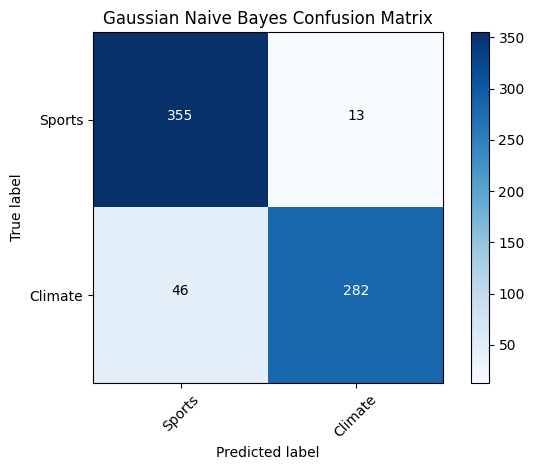

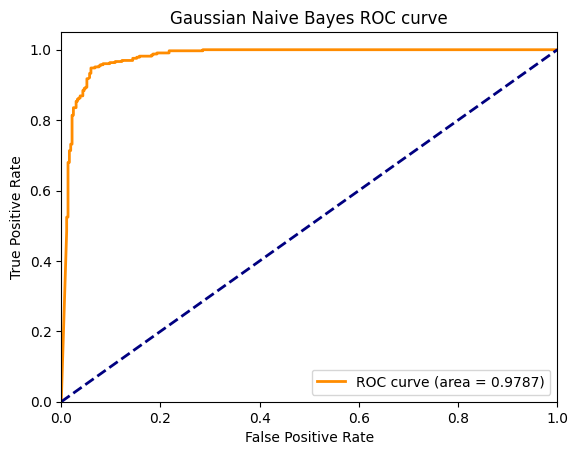

In [ ]:
#Training a GaussianNB classifier
gaussianNB = GaussianNB()
y_pred_gnb = gaussianNB.fit(X_train_LSI,train.label).predict(X_test_LSI)
print_metrics(test.label,y_pred_gnb,name="Gaussian Naive Bayes")

gaussianNB_confusion_matrix = confusion_matrix(test.label,y_pred_gnb) # Gaussian Naive Bayes confusion matrix
plt.figure();
plot_confusion_matrix(gaussianNB_confusion_matrix, classes=class_names, title='Gaussian Naive Bayes Confusion Matrix');
plot_roc_curve(test.label,gaussianNB.predict_proba(X_test_LSI)[:,1],name="Gaussian Naive Bayes") # Gaussian Naive Bayes ROC curve

QUESTION 7: Evaluate and profile a Naıve Bayes classifier: Train a GaussianNB classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.

> Refer to the figures above for ROC curve and confusion matrix.

> Accuracy score for Gaussian Naive Bayes: 0.915230

> Recall score for Gaussian Naive Bayes: 0.859756

> Precision score for Gaussian Naive Bayes: 0.955932

> F-1 score for Gaussian Naive Bayes: 0.905297

# **Question 8**

In [ ]:
#Function for stemming
analyzer = CountVectorizer().build_analyzer()
stemmer = PorterStemmer()
def stemmed (doc):
    return (stemmer.stem(word) for word in analyzer(doc) if word not in combined_stopwords and not word.isdigit())

def lemma(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

In [ ]:
#creating separate vectorizers for different min_df values and for different analyzers (stemming and lemmatization)
vectorizer_df3_with_lemmatization = CountVectorizer(min_df=3, analyzer=lemma)
vectorizer_df5_with_lemmatization = CountVectorizer(min_df=5, analyzer=lemma)
vectorizer_df3_with_stemming = CountVectorizer(min_df=3, analyzer=stemmed)
vectorizer_df5_with_stemming = CountVectorizer(min_df=5, analyzer=stemmed)

In [ ]:
#for caching
location = mkdtemp()
memory = Memory(location=location, verbose=10)

In [ ]:
#Providing all the parameters as provided in the question
parameter_grid = [
    {
        'vect': [vectorizer_df3_with_lemmatization,
                 vectorizer_df5_with_lemmatization,
                 vectorizer_df3_with_stemming,
                 vectorizer_df5_with_stemming],
        'reduce_dim': [TruncatedSVD(n_components=5, random_state=42),
                       TruncatedSVD(n_components=30, random_state=42),
                       TruncatedSVD(n_components=80, random_state=42),
                       NMF(n_components=5, init='random', max_iter=10000, random_state=42),
                       NMF(n_components=30, init='random', max_iter=10000, random_state=42),
                       NMF(n_components=80, init='random', max_iter=10000, random_state=42)],
        'clf': [LinearSVC(C=1.0,random_state=42),
                LogisticRegression(penalty='l1', C=100, max_iter=10000, random_state=42, solver='liblinear'),
                LogisticRegression(penalty='l2', C=1000, max_iter=10000, random_state=42),
                GaussianNB()]
    }
]

In [ ]:
#creating a pipeline
pipeline_complete = Pipeline([
    ('vect', vectorizer_df3_with_lemmatization),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('clf', LinearSVC(C=1)),
],
memory=memory
)
complete_grid = GridSearchCV(pipeline_complete, cv=5, n_jobs=1, param_grid=parameter_grid, scoring='accuracy')
complete_grid.fit(train['full_text'], train.label)
rmtree(location)

Streaming output truncated to the last 5000 lines.
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stemmed at 0x78838f76dbd0>, min_df=3), 2677    'While the four-day Aftershock's economic impa...
1204    'CBS Essentials is created independently of th...
2955    'Moderate-to-severe drought will likely contin...
2266    'Colleen Flood, the longtime co-owner of The F...
611     'WASHINGTON TRAFFIC MAY HAVE SAVED HIS LIFE. Y...
                              ...                        
1095    '(Photo by Justin Casterline/Getty Images)\n\n...
1130    'COOKEVILLE, Tenn. (WKRN) — The Golden Eagles ...
1294    'FanDuel Sportsbook has launched an exclusive ...
860     'Hunting stories are a Maine tradition, just l...
3174    'By Lewis Jackson\n\nSYDNEY (Reuters) -Thousan...
Name: full_text, Length: 2224, dtype: object, 
2677    1
1204    0
2955    1
2266

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_reduce_dim,param_vect,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,1.293373,0.366341,17.822207,0.589264,LinearSVC(random_state=42),"TruncatedSVD(n_components=80, random_state=42)",CountVectorizer(analyzer=<function lemma at 0x...,"{'clf': LinearSVC(random_state=42), 'reduce_di...",0.956835,0.965827,0.956835,0.958633,0.964029,0.960432,0.003773,1
45,0.246711,0.049638,17.900047,0.487919,"LogisticRegression(C=100, max_iter=10000, pena...","NMF(init='random', max_iter=10000, n_component...",CountVectorizer(analyzer=<function lemma at 0x...,"{'clf': LogisticRegression(C=100, max_iter=100...",0.955036,0.962230,0.958633,0.960432,0.960432,0.959353,0.002440,2
58,0.386332,0.152703,4.683975,1.082893,"LogisticRegression(C=1000, max_iter=10000, ran...","TruncatedSVD(n_components=80, random_state=42)",CountVectorizer(analyzer=<function stemmed at ...,"{'clf': LogisticRegression(C=1000, max_iter=10...",0.962230,0.962230,0.962230,0.951439,0.956835,0.958993,0.004317,3
56,0.385194,0.094850,17.519183,0.580558,"LogisticRegression(C=1000, max_iter=10000, ran...","TruncatedSVD(n_components=80, random_state=42)",CountVectorizer(analyzer=<function lemma at 0x...,"{'clf': LogisticRegression(C=1000, max_iter=10...",0.955036,0.962230,0.960432,0.958633,0.958633,0.958993,0.002386,3
33,0.420870,0.084127,17.820732,0.313845,"LogisticRegression(C=100, max_iter=10000, pena...","TruncatedSVD(n_components=80, random_state=42)",CountVectorizer(analyzer=<function lemma at 0x...,"{'clf': LogisticRegression(C=100, max_iter=100...",0.955036,0.962230,0.960432,0.958633,0.958633,0.958993,0.002386,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.163061,0.027319,17.580103,0.348253,GaussianNB(),"TruncatedSVD(n_components=30, random_state=42)",CountVectorizer(analyzer=<function lemma at 0x...,"{'clf': GaussianNB(), 'reduce_dim': TruncatedS...",0.915468,0.911871,0.913669,0.892086,0.924460,0.911511,0.010634,92
73,0.162254,0.037371,17.961799,0.613264,GaussianNB(),"TruncatedSVD(n_components=5, random_state=42)",CountVectorizer(analyzer=<function lemma at 0x...,"{'clf': GaussianNB(), 'reduce_dim': TruncatedS...",0.904676,0.857914,0.883094,0.870504,0.908273,0.884892,0.019371,93
75,0.148814,0.028766,4.657643,0.981739,GaussianNB(),"TruncatedSVD(n_components=5, random_state=42)",CountVectorizer(analyzer=<function stemmed at ...,"{'clf': GaussianNB(), 'reduce_dim': TruncatedS...",0.902878,0.865108,0.870504,0.872302,0.901079,0.882374,0.016191,94
72,0.173985,0.042874,18.301232,0.736464,GaussianNB(),"TruncatedSVD(n_components=5, random_state=42)",CountVectorizer(analyzer=<function lemma at 0x...,"{'clf': GaussianNB(), 'reduce_dim': TruncatedS...",0.902878,0.856115,0.861511,0.877698,0.872302,0.874101,0.016287,95


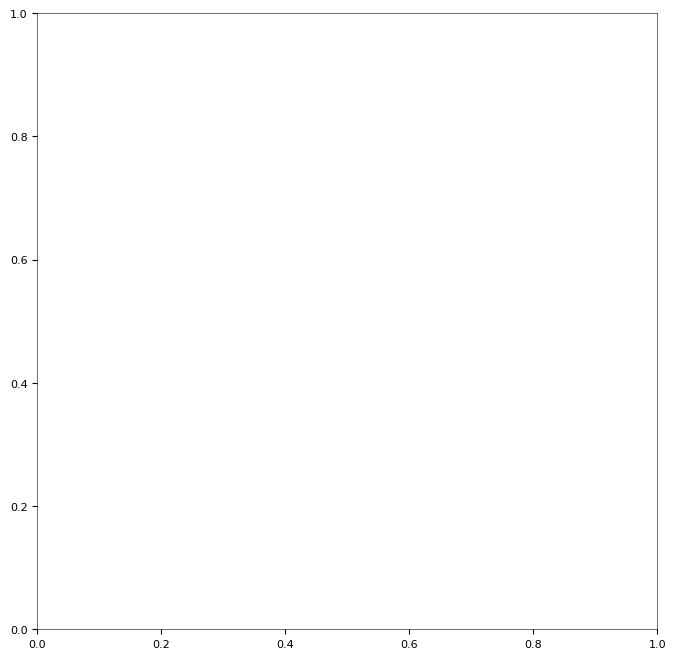

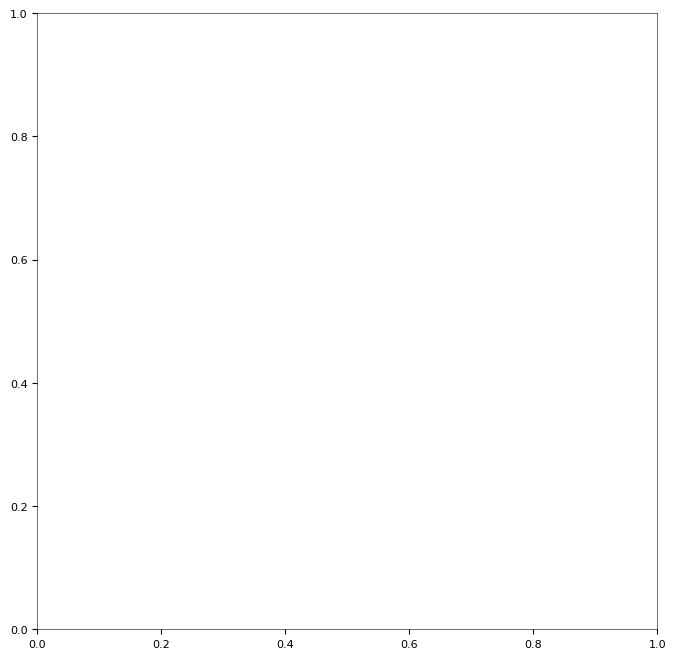

In [ ]:
#Printing the result in tabular form on the basis of ranks
gg = pd.DataFrame(complete_grid.cv_results_)
results = gg.sort_values(by='mean_test_score',ascending=False)
results

QUESTION 8: In this part, you will attempt to find the best model for binary classification.

• Construct a Pipeline that performs feature extraction, dimensionality reduction and classification;

• The evaluation of each combination is performed with 5-fold cross-validation (use the average validation set accuracy across folds).

• In addition to any other hyperparameters you choose, your gridsearch must at least include the table given in the pdf

• What are the 5 best combinations? Report their performances on the testing set

> Below are the best 5 combinations:

> 1.   SVM(C=1) + LSI(k=80) + lemmatization(min_df=5)
2.   Logistic Regression with L1 Regularization(C=100) + NMF(k=80) + lemmatization (min_df=5)
3. Logistic Regression with L2 Regularization(C=1000) + LSI(k=80) + stemming(min_df=3)
4. Logistic Regression with L2 Regularization(C=1000) + LSI(k=80) + lemmatization(min_df=3)
5. Logistic Regression with L1 Regularization(C=100) + LSI(k=80) + lemmatization (min_df=5)



# **Question 9**

In [17]:
#Using 3 columns while splitting into train and test
train_with_leaf_label, test_with_leaf_label = train_test_split(df[["full_text","root_label","leaf_label"]], test_size=0.2)
train_with_leaf_label.head()

,full_text,root_label,leaf_label
1368,"'On February 9th, 2025, the Super Bowl will be...",sports,football
2835,"'OMAHA, Neb. (WOWT) - Health experts at the Un...",climate,drought
2499,'A magnitude-4.8 earthquake was reported in No...,climate,earthquake
1046,'Serena Williams is getting candid about her m...,sports,tennis
1374,'Leonard Fournette #28 of the Tampa Bay Buccan...,sports,football


In [18]:
#Creating a new column with labels (Sports=0 and Climate=1)
train_with_leaf_label['root_label_encoded'] = np.where(train['root_label'].eq('sports'), 0, 1)
test_with_leaf_label['root_label_encoded'] = np.where(test['root_label'].eq('sports'), 0, 1)

#Creating a new column with leaf_label encoded
#map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis", 3:"football", 4:"soccer", 5:"forest fire", 6:"flood", 7:"earthquake", 8:"drought", 9:"heatwave"}
label_mapping = {"basketball": 0, "baseball": 1, "tennis": 2, "football": 3, "soccer": 4,
                 "forest fire": 5, "flood": 6, "earthquake": 7, "drought": 8, "heatwave": 9}

train_with_leaf_label['leaf_label_encoded'] = train_with_leaf_label['leaf_label'].map(label_mapping)
test_with_leaf_label['leaf_label_encoded'] = test_with_leaf_label['leaf_label'].map(label_mapping)

train_with_leaf_label.head()

,full_text,root_label,leaf_label,root_label_encoded,leaf_label_encoded
1368,"'On February 9th, 2025, the Super Bowl will be...",sports,football,1,3
2835,"'OMAHA, Neb. (WOWT) - Health experts at the Un...",climate,drought,0,8
2499,'A magnitude-4.8 earthquake was reported in No...,climate,earthquake,1,7
1046,'Serena Williams is getting candid about her m...,sports,tennis,1,2
1374,'Leonard Fournette #28 of the Tampa Bay Buccan...,sports,football,0,3


In [19]:
#cleaning the data
train_with_leaf_label['clean_data'] = train_with_leaf_label['full_text'].apply(clean)
test_with_leaf_label['clean_data'] = test_with_leaf_label['full_text'].apply(clean)
train_with_leaf_label.head()

,full_text,root_label,leaf_label,root_label_encoded,leaf_label_encoded,clean_data
1368,"'On February 9th, 2025, the Super Bowl will be...",sports,football,1,3,"'On February 9th, 2025, the Super Bowl will be..."
2835,"'OMAHA, Neb. (WOWT) - Health experts at the Un...",climate,drought,0,8,"'OMAHA, Neb. (WOWT) - Health experts at the Un..."
2499,'A magnitude-4.8 earthquake was reported in No...,climate,earthquake,1,7,'A magnitude-4.8 earthquake was reported in No...
1046,'Serena Williams is getting candid about her m...,sports,tennis,1,2,'Serena Williams is getting candid about her m...
1374,'Leonard Fournette #28 of the Tampa Bay Buccan...,sports,football,0,3,'Leonard Fournette #28 of the Tampa Bay Buccan...


In [20]:
#getting rid of digits and punctuations
train_with_leaf_label['clean_data'] = [re.sub(r'[^\w\s\d]', '', i) for i in train_with_leaf_label['clean_data']]
train_with_leaf_label['clean_data'] = [re.sub("\S*\d\S*", "", i).strip() for i in train_with_leaf_label['clean_data']]
test_with_leaf_label['clean_data'] = [re.sub(r'[^\w\s\d]', '', i) for i in test_with_leaf_label['clean_data']]
test_with_leaf_label['clean_data'] = [re.sub("\S*\d\S*", "", i).strip() for i in test_with_leaf_label['clean_data']]

In [21]:
#TF-IDF Transformation
count_vectorizer = CountVectorizer(min_df=5, analyzer=stem_rmv_punc)

X_train_counts=count_vectorizer.fit_transform(train_with_leaf_label["full_text"])
X_test_counts=count_vectorizer.transform(test_with_leaf_label["full_text"])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf.shape

(696, 9470)

In [22]:
#Creating a confusion matrix for the 10x10
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          classes = []
):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Multiclass NaiveBayes Confusion matrix: 

Confusion matrix, without normalization
[[47  3  3  2  3  0  0  0  0  0]
 [ 0 43 10  4  0  2  0  0  0  4]
 [ 0  6 41  3  5  6  1  1  1  4]
 [ 5  4  5 50  5  3  1  0  1  2]
 [ 1  4  5  2 59  2  0  0  0  2]
 [ 1  0  0  0  1 12  5  0  1 48]
 [ 0  3  2  0  0  6 40  0  6  7]
 [ 0  1  1  2  1  4  0 61  8  4]
 [ 0  1  1  1  0 18  2  0 42 13]
 [ 1  0  0  1  0 55  3  0  1  3]]


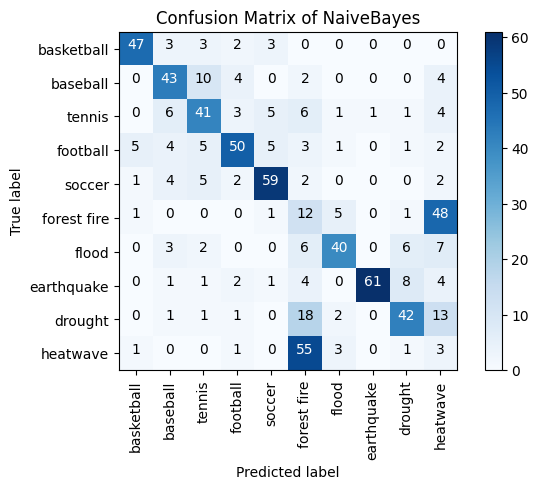

Multiclass NaiveBayes Accuracy Score: 0.5718390804597702
Multiclass NaiveBayes Recall Score: 0.5718390804597702
Multiclass NaiveBayes Precision Score: 0.5718390804597702
Multiclass NaiveBayes f1 Score: 0.5718390804597702


In [23]:
# Naive Bayes
multiclass_NB = GaussianNB()
classes = ["basketball", "baseball", "tennis", "football", "soccer", "forest fire", "flood", "earthquake", "drought", "heatwave"]
multiclass_NB.fit(X_train_tfidf.toarray(), train_with_leaf_label['leaf_label_encoded'])
multiclass_NB_pred = multiclass_NB.predict(X_test_tfidf.toarray())
multiclass_NB_confusion = confusion_matrix(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_NB_pred)
multiclass_NB_accuracy = accuracy_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_NB_pred)
multiclass_NB_recall = recall_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_NB_pred, average='micro')
multiclass_NB_precision = precision_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_NB_pred, average='micro')
multiclass_NB_f1 = f1_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_NB_pred, average='micro')
print("Multiclass NaiveBayes Confusion matrix: \n")
plot_confusion_matrix(multiclass_NB_confusion, classes = classes,title="Confusion Matrix of NaiveBayes")
print("Multiclass NaiveBayes Accuracy Score: " + str(multiclass_NB_accuracy))
print("Multiclass NaiveBayes Recall Score: " + str(multiclass_NB_recall))
print("Multiclass NaiveBayes Precision Score: " + str(multiclass_NB_precision))
print("Multiclass NaiveBayes f1 Score: " + str(multiclass_NB_f1))

Multiclass SVM OneVsOne Confusion matrix: 

Confusion matrix, without normalization
[[57  0  0  1  0  0  0  0  0  0]
 [ 0 55  3  2  0  0  0  0  0  3]
 [ 0  2 58  0  1  3  1  0  0  3]
 [ 0  1  0 72  1  0  0  0  0  2]
 [ 0  0  0  1 72  0  0  0  0  2]
 [ 0  1  0  0  0  8  0  0  2 57]
 [ 0  1  0  0  0  0 62  0  0  1]
 [ 0  0  1  0  0  3  2 76  0  0]
 [ 0  2  0  0  0  1  1  0 66  8]
 [ 0  1  0  0  0 54  0  0  1  8]]


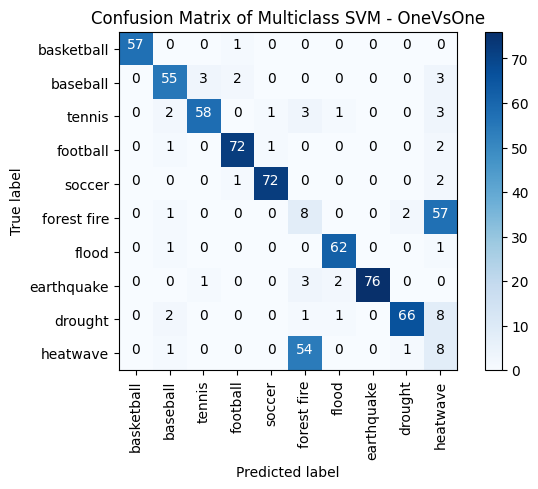

Multiclass SVM OneVsOne Accuracy Score: 0.7672413793103449
Multiclass SVM OneVsOne Recall Score: 0.7672413793103449
Multiclass SVM OneVsOne Precision Score: 0.7672413793103449
Multiclass SVM OneVsOne f1 Score: 0.7672413793103448


In [ ]:
#OneVsOne SVM
multiclass_svm_OneVsOne = OneVsOneClassifier(LinearSVC(random_state=42))

multiclass_svm_OneVsOne.fit(X_train_tfidf.toarray(), train_with_leaf_label['leaf_label_encoded'])
multiclass_svm_OneVsOne_pred = multiclass_svm_OneVsOne.predict(X_test_tfidf.toarray())
multiclass_svm_OneVsOne_confusion = confusion_matrix(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsOne_pred)
multiclass_svm_OneVsOne_accuracy = accuracy_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsOne_pred)
multiclass_svm_OneVsOne_recall = recall_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsOne_pred, average='micro')
multiclass_svm_OneVsOne_precision = precision_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsOne_pred, average='micro')
multiclass_svm_OneVsOne_f1 = f1_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsOne_pred, average='micro')
print("Multiclass SVM OneVsOne Confusion matrix: \n")
plot_confusion_matrix(multiclass_svm_OneVsOne_confusion, classes = classes, title="Confusion Matrix of Multiclass SVM - OneVsOne")
print("Multiclass SVM OneVsOne Accuracy Score: " + str(multiclass_svm_OneVsOne_accuracy))
print("Multiclass SVM OneVsOne Recall Score: " + str(multiclass_svm_OneVsOne_recall))
print("Multiclass SVM OneVsOne Precision Score: " + str(multiclass_svm_OneVsOne_precision))
print("Multiclass SVM OneVsOne f1 Score: " + str(multiclass_svm_OneVsOne_f1))

Multiclass SVM OneVsRest Confusion matrix: 

Confusion matrix, without normalization
[[57  0  0  1  0  0  0  0  0  0]
 [ 0 55  3  2  0  0  0  0  0  3]
 [ 1  1 58  0  2  3  1  0  0  2]
 [ 1  0  0 72  1  0  0  0  0  2]
 [ 0  0  0  1 73  0  0  0  0  1]
 [ 0  1  1  0  0  7  1  0  2 56]
 [ 0  1  0  0  0  0 63  0  0  0]
 [ 0  1  0  0  0  1  2 78  0  0]
 [ 0  3  1  0  0  3  2  1 66  2]
 [ 0  1  0  0  0 54  0  0  1  8]]


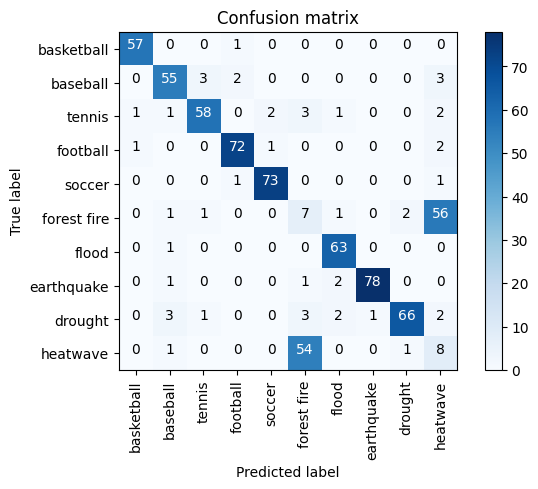

Multiclass SVM OneVsRest Accuracy Score: 0.771551724137931
Multiclass SVM OneVsRest Recall Score: 0.771551724137931
Multiclass SVM OneVsRest Precision Score: 0.771551724137931
Multiclass SVM OneVsRest f1 Score: 0.771551724137931


In [ ]:
#OneVsRest SVM
multiclass_svm_OneVsRest = OneVsRestClassifier(LinearSVC(random_state=42))

multiclass_svm_OneVsRest.fit(X_train_tfidf.toarray(), train_with_leaf_label['leaf_label_encoded'])
multiclass_svm_OneVsRest_pred = multiclass_svm_OneVsRest.predict(X_test_tfidf.toarray())
multiclass_svm_OneVsRest_confusion = confusion_matrix(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsRest_pred)
multiclass_svm_OneVsRest_accuracy = accuracy_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsRest_pred)
multiclass_svm_OneVsRest_recall = recall_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsRest_pred, average='micro')
multiclass_svm_OneVsRest_precision = precision_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsRest_pred, average='micro')
multiclass_svm_OneVsRest_f1 = f1_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsRest_pred, average='micro')
print("Multiclass SVM OneVsRest Confusion matrix: \n")
plot_confusion_matrix(multiclass_svm_OneVsRest_confusion, classes = classes)
print("Multiclass SVM OneVsRest Accuracy Score: " + str(multiclass_svm_OneVsRest_accuracy))
print("Multiclass SVM OneVsRest Recall Score: " + str(multiclass_svm_OneVsRest_recall))
print("Multiclass SVM OneVsRest Precision Score: " + str(multiclass_svm_OneVsRest_precision))
print("Multiclass SVM OneVsRest f1 Score: " + str(multiclass_svm_OneVsRest_f1))

In [24]:
#Merging the two leaf_labels i.e forest fire and heatwave into a single leaf_label
#According to original labelling, forest fire was 5 and heatwave was 9. Merged the new label to forest fire + heatwave with mapping to 5
merged_label_list = ["basketball", "baseball", "tennis", "football", "soccer",  "forest fire + heatwave", "flood", "earthquake", "drought",]

train_with_leaf_label['leaf_label_encoded'] = train_with_leaf_label['leaf_label_encoded'].copy()
train_with_leaf_label['leaf_label_encoded'][np.isin(train_with_leaf_label['leaf_label_encoded'], [5, 9])] = 5

test_with_leaf_label['leaf_label_encoded'] = test_with_leaf_label['leaf_label_encoded'].copy()
test_with_leaf_label['leaf_label_encoded'][np.isin(test_with_leaf_label['leaf_label_encoded'], [5, 9])] = 5


<ipython-input-24-d0b0e97529ca>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_with_leaf_label['leaf_label_encoded'][np.isin(train_with_leaf_label['leaf_label_encoded'], [5, 9])] = 5
<ipython-input-24-d0b0e97529ca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_with_leaf_label['leaf_label_encoded'][np.isin(test_with_leaf_label['leaf_label_encoded'], [5, 9])] = 5


Multiclass NaiveBayes with leaf labels merged Confusion matrix: 

Confusion matrix, without normalization
[[ 47   3   3   2   3   0   0   0   0]
 [  0  43  10   4   0   6   0   0   0]
 [  0   6  41   3   5  11   1   1   0]
 [  5   4   4  50   5   6   1   0   1]
 [  1   4   5   2  57   6   0   0   0]
 [  2   0   0   1   1 118   8   0   2]
 [  0   3   2   0   0  15  39   0   5]
 [  0   1   1   2   1   8   0  61   8]
 [  0   1   1   1   0  31   2   0  42]]


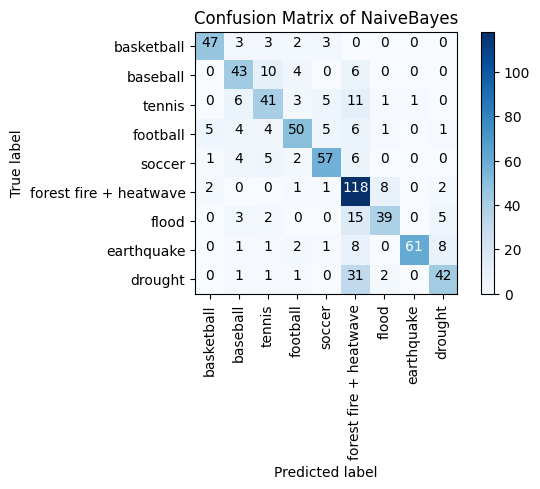

Multiclass NaiveBayes with leaf labels merged Accuracy Score: 0.7155172413793104
Multiclass NaiveBayes with leaf labels merged Recall Score: 0.7155172413793104
Multiclass NaiveBayes with leaf labels merged Precision Score: 0.7155172413793104
Multiclass NaiveBayes with leaf labels merged f1 Score: 0.7155172413793104


In [25]:
#Naive bayes with leaf labels merged
multiclass_NB = GaussianNB()
classes = ["basketball", "baseball", "tennis", "football", "soccer", "forest fire + heatwave", "flood", "earthquake", "drought"]
multiclass_NB.fit(X_train_tfidf.toarray(), train_with_leaf_label['leaf_label_encoded'])
multiclass_NB_pred = multiclass_NB.predict(X_test_tfidf.toarray())
multiclass_NB_confusion = confusion_matrix(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_NB_pred)
multiclass_NB_accuracy = accuracy_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_NB_pred)
multiclass_NB_recall = recall_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_NB_pred, average='micro')
multiclass_NB_precision = precision_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_NB_pred, average='micro')
multiclass_NB_f1 = f1_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_NB_pred, average='micro')
print("Multiclass NaiveBayes with leaf labels merged Confusion matrix: \n")
plot_confusion_matrix(multiclass_NB_confusion, classes = classes,title="Confusion Matrix of NaiveBayes")
print("Multiclass NaiveBayes with leaf labels merged Accuracy Score: " + str(multiclass_NB_accuracy))
print("Multiclass NaiveBayes with leaf labels merged Recall Score: " + str(multiclass_NB_recall))
print("Multiclass NaiveBayes with leaf labels merged Precision Score: " + str(multiclass_NB_precision))
print("Multiclass NaiveBayes with leaf labels merged f1 Score: " + str(multiclass_NB_f1))

Multiclass SVM OneVsOne with leaf labels merged Confusion matrix: 

Confusion matrix, without normalization
[[ 63   3   0   2   0   1   0   0   0]
 [  0  63   0   1   0   4   0   0   0]
 [  0   2  60   0   1   2   0   0   0]
 [  0   2   2  62   0   0   0   0   0]
 [  0   2   0   3  71   2   0   0   0]
 [  0   0   0   0   0 157   0   0   0]
 [  0   0   0   0   0   2  55   0   0]
 [  0   2   0   0   0   1   0  70   0]
 [  0   2   0   0   0   6   2   1  52]]


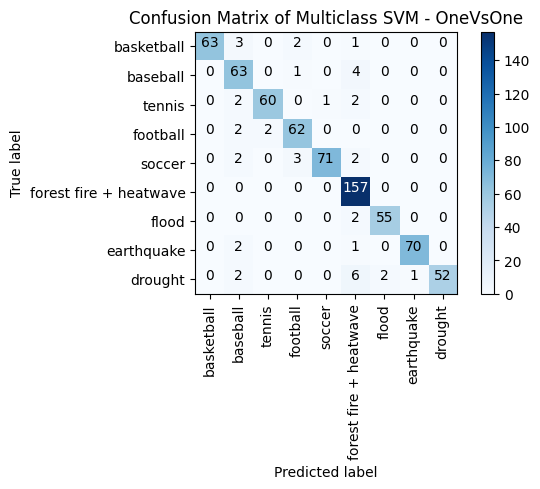

Multiclass SVM OneVsOne with leaf labels merged Accuracy Score: 0.9382183908045977
Multiclass SVM OneVsOne with leaf labels merged Recall Score: 0.9382183908045977
Multiclass SVM OneVsOne with leaf labels merged Precision Score: 0.9382183908045977
Multiclass SVM OneVsOne with leaf labels merged f1 Score: 0.9382183908045977


In [ ]:
#OneVsOne SVM with leaf labels merged
multiclass_svm_OneVsOne = OneVsOneClassifier(LinearSVC(random_state=42))

multiclass_svm_OneVsOne.fit(X_train_tfidf.toarray(), train_with_leaf_label['leaf_label_encoded'])
multiclass_svm_OneVsOne_pred = multiclass_svm_OneVsOne.predict(X_test_tfidf.toarray())
multiclass_svm_OneVsOne_confusion = confusion_matrix(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsOne_pred)
multiclass_svm_OneVsOne_accuracy = accuracy_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsOne_pred)
multiclass_svm_OneVsOne_recall = recall_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsOne_pred, average='micro')
multiclass_svm_OneVsOne_precision = precision_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsOne_pred, average='micro')
multiclass_svm_OneVsOne_f1 = f1_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsOne_pred, average='micro')
print("Multiclass SVM OneVsOne with leaf labels merged Confusion matrix: \n")
plot_confusion_matrix(multiclass_svm_OneVsOne_confusion, classes = classes, title="Confusion Matrix of Multiclass SVM - OneVsOne")
print("Multiclass SVM OneVsOne with leaf labels merged Accuracy Score: " + str(multiclass_svm_OneVsOne_accuracy))
print("Multiclass SVM OneVsOne with leaf labels merged Recall Score: " + str(multiclass_svm_OneVsOne_recall))
print("Multiclass SVM OneVsOne with leaf labels merged Precision Score: " + str(multiclass_svm_OneVsOne_precision))
print("Multiclass SVM OneVsOne with leaf labels merged f1 Score: " + str(multiclass_svm_OneVsOne_f1))

Multiclass SVM OneVsRest with leaf labels merged Confusion matrix: 

Confusion matrix, without normalization
[[ 65   1   0   2   0   1   0   0   0]
 [  0  63   1   1   0   3   0   0   0]
 [  0   1  60   0   1   3   0   0   0]
 [  1   0   1  64   0   0   0   0   0]
 [  0   2   0   4  70   2   0   0   0]
 [  0   0   1   0   0 156   0   0   0]
 [  0   0   0   0   0   2  55   0   0]
 [  0   1   0   0   1   0   0  71   0]
 [  0   2   0   0   0   5   3   1  52]]


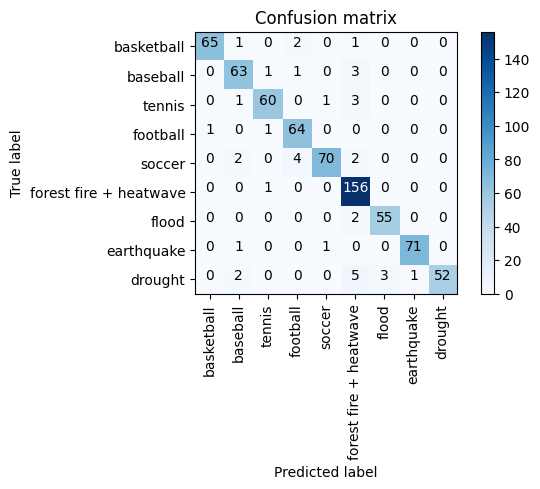

Multiclass SVM OneVsRest with leaf labels merged Accuracy Score: 0.9425287356321839
Multiclass SVM OneVsRest with leaf labels merged Recall Score: 0.9425287356321839
Multiclass SVM OneVsRest with leaf labels merged Precision Score: 0.9425287356321839
Multiclass SVM OneVsRest with leaf labels merged f1 Score: 0.9425287356321839


In [ ]:
#OneVsRest SVM with leaf labels merged
multiclass_svm_OneVsRest = OneVsRestClassifier(LinearSVC(random_state=42))

multiclass_svm_OneVsRest.fit(X_train_tfidf.toarray(), train_with_leaf_label['leaf_label_encoded'])
multiclass_svm_OneVsRest_pred = multiclass_svm_OneVsRest.predict(X_test_tfidf.toarray())
multiclass_svm_OneVsRest_confusion = confusion_matrix(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsRest_pred)
multiclass_svm_OneVsRest_accuracy = accuracy_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsRest_pred)
multiclass_svm_OneVsRest_recall = recall_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsRest_pred, average='micro')
multiclass_svm_OneVsRest_precision = precision_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsRest_pred, average='micro')
multiclass_svm_OneVsRest_f1 = f1_score(y_true=test_with_leaf_label['leaf_label_encoded'], y_pred=multiclass_svm_OneVsRest_pred, average='micro')
print("Multiclass SVM OneVsRest with leaf labels merged Confusion matrix: \n")
plot_confusion_matrix(multiclass_svm_OneVsRest_confusion, classes = classes)
print("Multiclass SVM OneVsRest with leaf labels merged Accuracy Score: " + str(multiclass_svm_OneVsRest_accuracy))
print("Multiclass SVM OneVsRest with leaf labels merged Recall Score: " + str(multiclass_svm_OneVsRest_recall))
print("Multiclass SVM OneVsRest with leaf labels merged Precision Score: " + str(multiclass_svm_OneVsRest_precision))
print("Multiclass SVM OneVsRest with leaf labels merged f1 Score: " + str(multiclass_svm_OneVsRest_f1))

(1188, 9470)
Multiclass SVM OneVsOne with leaf labels merged with class imbalance resolved Confusion matrix: 

Confusion matrix, without normalization
[[129   0   0   3   0   0   0   0   0]
 [  0 123   2   3   0   4   0   0   0]
 [  0   2 115   0   4   9   2   0   0]
 [  0   1   0 128   1   1   1   0   0]
 [  0   0   0   1 129   2   0   0   0]
 [  0   2   1   0   0 122   6   0   1]
 [  0   1   0   0   0   1 130   0   0]
 [  0   0   0   0   0   3   2 127   0]
 [  0   3   0   0   0  10   1   0 118]]


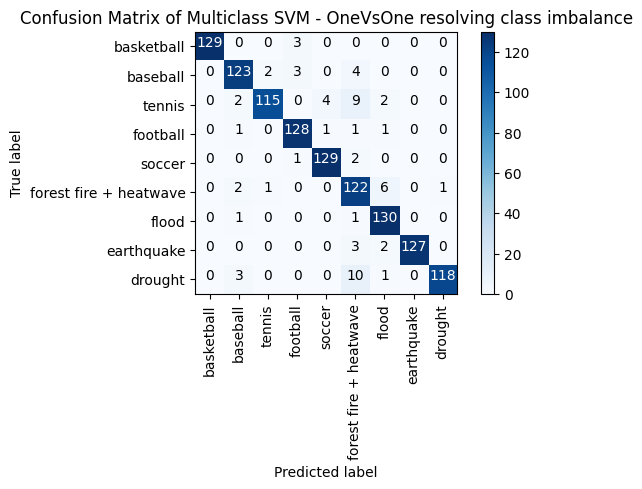

Multiclass SVM OneVsOne with leaf labels merged and resolving class imbalance Accuracy Score: 0.9436026936026936
Multiclass SVM OneVsOne with leaf labels merged and resolving class imbalance Recall Score: 0.9436026936026936
Multiclass SVM OneVsOne with leaf labels merged and resolving class imbalance Precision Score: 0.9436026936026936
Multiclass SVM OneVsOne with leaf labels merged and resolving class imbalance f1 Score: 0.9436026936026936


In [26]:
#OneVsOne SVM with leaf labels merged and resolving class imbalance using SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x1_train, y1_train = oversample.fit_resample(X_train_tfidf, train_with_leaf_label["leaf_label_encoded"])
x1_test, y1_test = oversample.fit_resample(X_test_tfidf, test_with_leaf_label["leaf_label_encoded"])
print(x1_test.shape)
multiclass_svm_OneVsOne_ResolvingClassImbalance = OneVsOneClassifier(LinearSVC(random_state=42))

multiclass_svm_OneVsOne_ResolvingClassImbalance.fit(x1_train, y1_train)
multiclass_svm_OneVsOne_ResolvingClassImbalance_pred = multiclass_svm_OneVsOne_ResolvingClassImbalance.predict(x1_test)
multiclass_svm_OneVsOne_ResolvingClassImbalance_confusion = confusion_matrix(y_true=y1_test, y_pred=multiclass_svm_OneVsOne_ResolvingClassImbalance_pred)
multiclass_svm_OneVsOne_ResolvingClassImbalance_accuracy = accuracy_score(y_true=y1_test, y_pred=multiclass_svm_OneVsOne_ResolvingClassImbalance_pred)
multiclass_svm_OneVsOne_ResolvingClassImbalance_recall = recall_score(y_true=y1_test, y_pred=multiclass_svm_OneVsOne_ResolvingClassImbalance_pred, average='micro')
multiclass_svm_OneVsOne_ResolvingClassImbalance_precision = precision_score(y_true=y1_test, y_pred=multiclass_svm_OneVsOne_ResolvingClassImbalance_pred, average='micro')
multiclass_svm_OneVsOne_ResolvingClassImbalance_f1 = f1_score(y_true=y1_test, y_pred=multiclass_svm_OneVsOne_ResolvingClassImbalance_pred, average='micro')
print("Multiclass SVM OneVsOne with leaf labels merged with class imbalance resolved Confusion matrix: \n")
plot_confusion_matrix(multiclass_svm_OneVsOne_ResolvingClassImbalance_confusion, classes = classes, title="Confusion Matrix of Multiclass SVM - OneVsOne resolving class imbalance")
print("Multiclass SVM OneVsOne with leaf labels merged and resolving class imbalance Accuracy Score: " + str(multiclass_svm_OneVsOne_ResolvingClassImbalance_accuracy))
print("Multiclass SVM OneVsOne with leaf labels merged and resolving class imbalance Recall Score: " + str(multiclass_svm_OneVsOne_ResolvingClassImbalance_recall))
print("Multiclass SVM OneVsOne with leaf labels merged and resolving class imbalance Precision Score: " + str(multiclass_svm_OneVsOne_ResolvingClassImbalance_precision))
print("Multiclass SVM OneVsOne with leaf labels merged and resolving class imbalance f1 Score: " + str(multiclass_svm_OneVsOne_ResolvingClassImbalance_f1))

Multiclass SVM OneVsRest with leaf labels merged with class imbalance resolved Confusion matrix: 

Confusion matrix, without normalization
[[129   0   0   3   0   0   0   0   0]
 [  0 123   2   3   0   4   0   0   0]
 [  0   2 115   0   4   9   2   0   0]
 [  0   1   0 128   1   1   1   0   0]
 [  0   0   0   1 129   2   0   0   0]
 [  0   2   1   0   0 122   6   0   1]
 [  0   1   0   0   0   1 130   0   0]
 [  0   0   0   0   0   3   2 127   0]
 [  0   3   0   0   0  10   1   0 118]]


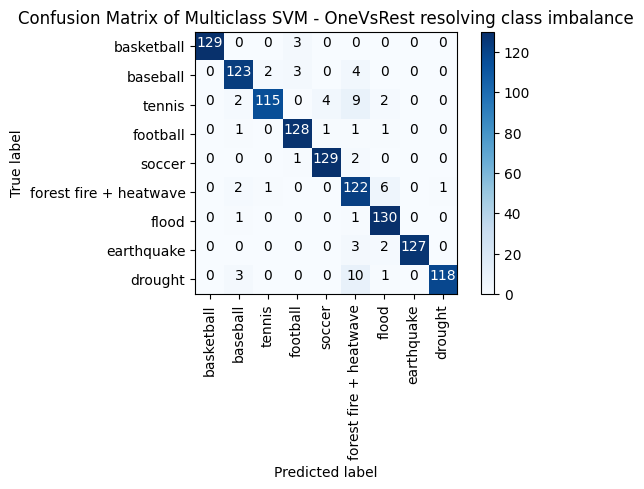

Multiclass SVM OneVsRest with leaf labels merged and resolving class imbalance Accuracy Score: 0.9461279461279462
Multiclass SVM OneVsRest with leaf labels merged and resolving class imbalance Recall Score: 0.9461279461279462
Multiclass SVM OneVsRest with leaf labels merged and resolving class imbalance Precision Score: 0.9461279461279462
Multiclass SVM OneVsRest with leaf labels merged and resolving class imbalance f1 Score: 0.9461279461279462


In [27]:
#OneVsRest SVM with leaf labels merged and resolving class imbalance using SMOTE
multiclass_svm_OneVsRest_ResolvingClassImbalance = OneVsRestClassifier(LinearSVC(random_state=42))

multiclass_svm_OneVsRest_ResolvingClassImbalance.fit(x1_train, y1_train)
multiclass_svm_OneVsRest_ResolvingClassImbalance_pred = multiclass_svm_OneVsRest_ResolvingClassImbalance.predict(x1_test)
multiclass_svm_OneVsRest_ResolvingClassImbalance_confusion = confusion_matrix(y_true=y1_test, y_pred=multiclass_svm_OneVsRest_ResolvingClassImbalance_pred)
multiclass_svm_OneVsRest_ResolvingClassImbalance_accuracy = accuracy_score(y_true=y1_test, y_pred=multiclass_svm_OneVsRest_ResolvingClassImbalance_pred)
multiclass_svm_OneVsRest_ResolvingClassImbalance_recall = recall_score(y_true=y1_test, y_pred=multiclass_svm_OneVsRest_ResolvingClassImbalance_pred, average='micro')
multiclass_svm_OneVsRest_ResolvingClassImbalance_precision = precision_score(y_true=y1_test, y_pred=multiclass_svm_OneVsRest_ResolvingClassImbalance_pred, average='micro')
multiclass_svm_OneVsRest_ResolvingClassImbalance_f1 = f1_score(y_true=y1_test, y_pred=multiclass_svm_OneVsRest_ResolvingClassImbalance_pred, average='micro')
print("Multiclass SVM OneVsRest with leaf labels merged with class imbalance resolved Confusion matrix: \n")
plot_confusion_matrix(multiclass_svm_OneVsOne_ResolvingClassImbalance_confusion, classes = classes, title="Confusion Matrix of Multiclass SVM - OneVsRest resolving class imbalance")
print("Multiclass SVM OneVsRest with leaf labels merged and resolving class imbalance Accuracy Score: " + str(multiclass_svm_OneVsRest_ResolvingClassImbalance_accuracy))
print("Multiclass SVM OneVsRest with leaf labels merged and resolving class imbalance Recall Score: " + str(multiclass_svm_OneVsRest_ResolvingClassImbalance_recall))
print("Multiclass SVM OneVsRest with leaf labels merged and resolving class imbalance Precision Score: " + str(multiclass_svm_OneVsRest_ResolvingClassImbalance_precision))
print("Multiclass SVM OneVsRest with leaf labels merged and resolving class imbalance f1 Score: " + str(multiclass_svm_OneVsRest_ResolvingClassImbalance_f1))

QUESTION 9: In this part, we aim to learn classifiers on the documents belonging to unique classes in the column leaf label.
Perform Na¨ıve Bayes classification and multiclass SVM classification (with both One VS One and One VS the rest methods described above) and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of your classifiers. How did you resolve the class imbalance issue in the One VS the rest model?

> Naive Bayes classification

>>Multiclass NaiveBayes Accuracy Score: 0.5718390804597702

>>Multiclass NaiveBayes Recall Score: 0.5718390804597702

>>Multiclass NaiveBayes Precision Score: 0.5718390804597702

>>Multiclass NaiveBayes f1 Score: 0.5718390804597702

> Multiclass SVM (One vs One):

>>Multiclass SVM OneVsOne Accuracy Score: 0.7672413793103449

>>Multiclass SVM OneVsOne Recall Score: 0.7672413793103449

>>Multiclass SVM OneVsOne Precision Score: 0.7672413793103449

>>Multiclass SVM OneVsOne f1 Score: 0.7672413793103448

>Multiclass SVM (One vs Rest):

>>Multiclass SVM OneVsRest Accuracy Score: 0.771551724137931

>>Multiclass SVM OneVsRest Recall Score: 0.771551724137931

>>Multiclass SVM OneVsRest Precision Score: 0.771551724137931

>>Multiclass SVM OneVsRest f1 Score: 0.771551724137931

In addition, answer the following questions:
* In the confusion matrix you should have an 10 × 10 matrix where 10 is the number of unique labels in the column leaf label. Please make sure that the order of these labels is as follows:

map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis",
3:"football", 4:"soccer", 5:"forest fire", 6:"flood",
7:"earthquake", 8:"drought", 9:"heatwave"}

Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?

> We can see that the class leaf_label is a little imbalanced.From all the results, we see that One vs Rest SVM classifier performs the best. From the confusion matrix, we can see that we have a distinct diagonal. The diagonal elements of a confusion matrix show the labels that are predicted correctly. The off diagonal elements are the misclassified labels. Except for forest fire and heatwave, we can see that the remaining have a perfect diagonal. The distinct visible diagonals in the block leads to a higher accuracy.

* Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix. How did the accuracy change in One VS One and One VS the rest?

> We can see that forest fire and heatwave do not have a perfect diagonal meaning there are more misclassified labels. Merging forest fire and heatwave into a single label and checking gives a higher accuracy for all 3 models.


>Naive Bayes:

>>Multiclass NaiveBayes with leaf labels merged Accuracy Score: 0.7298850574712644

>>Multiclass NaiveBayes with leaf labels merged Recall Score: 0.7298850574712644

>>Multiclass NaiveBayes with leaf labels merged Precision Score: 0.7298850574712644

>>Multiclass NaiveBayes with leaf labels merged f1 Score: 0.7298850574712644

>Multiclass SVM (One vs One):

>>Multiclass SVM OneVsOne with leaf labels merged Accuracy Score: 0.9382183908045977

>>Multiclass SVM OneVsOne with leaf labels merged Recall Score: 0.9382183908045977

>>Multiclass SVM OneVsOne with leaf labels merged Precision Score: 0.9382183908045977

>>Multiclass SVM OneVsOne with leaf labels merged f1 Score: 0.9382183908045977

>Multiclass SVM (One vs Rest):

>>Multiclass SVM OneVsRest with leaf labels merged Accuracy Score: 0.9425287356321839

>>Multiclass SVM OneVsRest with leaf labels merged Recall Score: 0.9425287356321839

>>Multiclass SVM OneVsRest with leaf labels merged Precision Score: 0.9425287356321839

>>Multiclass SVM OneVsRest with leaf labels merged f1 Score: 0.9425287356321839

>For all 3 models i.e Naive Bayes, OneVsOne SVM and OneVsRest SVM, the accuracy increased drastically and we get a perfect diagonal in the confusion matrix.

* Does class imbalance impact the performance of the classification once some classes are merged? Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix in One VS One and One VS the rest?.

>Yes the class imbalance affects the classification since we have almost twice the number of data points as compared to the rest of the leaf labels. The solution to this is either double the samples for the remaining leaf labels or then reduce the sample size to half for this new merged leaf label (forest fire + heatwave). In this way we will be able to deal with the class imbalance. Using SMOTE can help resolve this class imbalance issue.

>Multiclass SVM (One vs One):

>>Multiclass SVM OneVsOne with leaf labels merged and resolving class imbalance Accuracy Score: 0.9436026936026936

>>Multiclass SVM OneVsOne with leaf labels merged and resolving class imbalance Recall Score: 0.9436026936026936

>>Multiclass SVM OneVsOne with leaf labels merged and resolving class imbalance Precision Score: 0.9436026936026936

>>Multiclass SVM OneVsOne with leaf labels merged and resolving class imbalance f1 Score: 0.9436026936026936

>Multiclass SVM (One vs Rest):

>>Multiclass SVM OneVsRest with leaf labels merged and resolving class imbalance Accuracy Score: 0.9461279461279462

>>Multiclass SVM OneVsRest with leaf labels merged and resolving class imbalance Recall Score: 0.9461279461279462

>>Multiclass SVM OneVsRest with leaf labels merged and resolving class imbalance Precision Score: 0.9461279461279462

>>Multiclass SVM OneVsRest with leaf labels merged and resolving class imbalance f1 Score: 0.9461279461279462

>We can see that after dealing with the issue of class imbalance, the accuracy has increased for both OveVsOne SVM and OneVsRest SVM.

# **Question 10**

In [17]:
#Forming a dictionary of the words and vector in GLoVE
embeddings_dict = {}
dimension_of_glove = 300
with open("gdrive/My Drive/Winter Quarter 2024/219 - Large Scale Data Mining/glove.6B.300d.txt", 'r') as f:

    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [18]:
print(embeddings_dict.get("woman"))

[-0.51821   -0.13809   -0.41185   -0.13133    0.0035659 -0.31205
 -0.31242   -0.43538   -0.27017   -1.1338     0.19282   -0.23786
  0.0028892 -0.027078   0.14747   -0.051265   0.089021  -0.12337
 -0.40892   -0.39197   -0.5665     0.40684   -0.057313   0.18613
 -0.33095   -0.25243    0.33452   -0.23104   -0.0099149  0.24269
 -0.57504    0.30122   -0.33779   -0.294     -0.80202    0.44674
 -0.40296   -0.21026    0.1072     0.53937    0.63971   -0.3154
 -0.082537  -0.038314  -0.058821   0.11235    0.50928    0.14656
 -0.18988    0.24132   -0.038442   0.071418   0.38471    0.10584
 -0.52786   -0.057574   0.13771   -0.48613    0.62553   -0.3308
 -0.065539   0.1791     0.62746    0.087208  -0.60422   -0.64595
 -0.2389    -0.1585    -0.07948   -0.037848  -0.205     -0.44504
 -0.21127   -0.0026664 -0.0080152  0.39607    0.069091  -0.34379
 -0.13992    0.084029  -0.40245    0.094426   0.28908    0.6216
 -0.4132    -0.12153   -0.40676   -0.05771    0.17415    0.094069
 -0.65955   -0.34154   -0.0

In [19]:
#Changing glove to vector
glove_filename='glove.6B.300d.txt'
glove_path = "gdrive/My Drive/Winter Quarter 2024/219 - Large Scale Data Mining/glove.6B.300d.txt"
word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_path, word2vec_output_file)
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

<ipython-input-19-ac0af3c22a75>:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


In [20]:
#Finding similar words
result_woman = model.similar_by_word("woman")
print("woman is similar to {}: {:.4f}".format(*result_woman[0]))

woman is similar to girl: 0.7296


In [21]:
from scipy.spatial.distance import cosine
word1 = 'woman'
word2 = 'man'
similarity = 1 - cosine(embeddings_dict[word1], embeddings_dict[word2])
difference = np.linalg.norm(embeddings_dict[word1]-embeddings_dict[word2])
print(f"Similarity between '{word1}' and '{word2}': {similarity}")
print(f"Difference between '{word1}' and '{word2}': {difference}")

Similarity between 'woman' and 'man': 0.6998663544654846
Difference between 'woman' and 'man': 4.753939628601074


In [22]:
word1 = 'wife'
word2 = 'husband'
similarity = 1 - cosine(embeddings_dict[word1], embeddings_dict[word2])
difference = np.linalg.norm(embeddings_dict[word1]-embeddings_dict[word2])
print(f"Similarity between '{word1}' and '{word2}': {similarity}")
print(f"Difference between '{word1}' and '{word2}': {difference}")

Similarity between 'wife' and 'husband': 0.8646390438079834
Difference between 'wife' and 'husband': 3.1520464420318604


In [23]:
word1 = 'wife'
word2 = 'orange'
similarity = 1 - cosine(embeddings_dict[word1], embeddings_dict[word2])
difference = np.linalg.norm(embeddings_dict[word1]-embeddings_dict[word2])
print(f"Similarity between '{word1}' and '{word2}': {similarity}")
print(f"Difference between '{word1}' and '{word2}': {difference}")

Similarity between 'wife' and 'orange': 0.1162913516163826
Difference between 'wife' and 'orange': 8.667715072631836


QUESTION 10: Read the paper about GLoVE embeddings - found here and answer the following subquestions:

(a) Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than the probabilities themselves?

> GLoVE embeddings are trained on the ratio of co-occurrence probabilities rather than the probabilities themselves because the ratio of probabilities has some advantages in capturing meaningful relationships between words. GloVe tries to capture the relation between words based on their co-occurrence probabilities. Using these ratios of probabilities, the model emphasizes relative comparisons between the probabilities of different word pairs rather than the absolute values. Using these ratios helps mitigate the impact of word frequency on the embeddings. The ratio formulation inherently normalizes the co-occurrence information. It captures semantic relationships between words. It captures meaningful semantic relationships between words while addressing challenges related to frequency effects, normalization, and sparsity.


(b) In the two sentences: “James is running in the park.” and “James is running for the presidency.”, would GLoVE embeddings return the same vector for the word running in both cases? Why or why not?

> No, we will not get the same vector for the word running in both the cases. This is because while forming the vector, GLoVE takes into consideration the neighboring words i.e the contextual dependencies of the words in the sentence. Here, park and presidency are two different neighboring words and hence we get different vectors.

(c) What do you expect for the values of,
||GLoVE["woman"] - GLoVE["man"]||2, ||GLoVE["wife"] - GLoVE["husband"]||2 and
||GLoVE["wife"] - GLoVE["orange"]||2 ? Compare these values.

> Similarity between 'woman' and 'man': 0.6998663544654846

> Difference between 'woman' and 'man': 4.753939628601074

>Similarity between 'wife' and 'husband': 0.8646390438079834

>Difference between 'wife' and 'husband': 3.1520464420318604

>Similarity between 'wife' and 'orange': 0.1162913516163826

>Difference between 'wife' and 'orange': 8.667715072631836

>> We can see that from the three pairs above, wife and husband have the least difference i.e they are the most similar. This is followed by woman and man. Wife and orange have a high difference which means they are not very similar. Wife and husband have a strong semantic relationship. This is due to the spousal and gender relationship. Man and woman have a gender relationship. Wife and orange have a larger norm and are not related.

(d) Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding?

>Generally, lemmatization is preferred over stemming. This is because lemmatization takes into consideration context, syntax, semantics and POS tokens and hence we get meaningful words. Whereas in stemming, it is not necessary that we get meaningful words. Although stemming is faster and computationally efficient, it has a higher error rate. Therefore, it is preferred to choose lemmatization for a broader, more meaningful words before mapping it to its GLoVE embedding.


# **Question 11**

In [ ]:
from nltk.tokenize import word_tokenize
#Function used to tokenize and get the embeddings
def get_document_embeddings(text, embeddings_dict):
    text = re.sub(r'[^\w\s]','', text)
    tokens = word_tokenize(text)
    embeddings = [embeddings_dict[word] for word in tokens if word in embeddings_dict]
    return embeddings

def average_document_embedding(text_embeddings):
    normalized_embeddings = [embedding / np.linalg.norm(embedding) for embedding in text_embeddings]
    avg_text_embedding = np.mean(normalized_embeddings, axis=0)
    return avg_text_embedding

def get_glove_document_embedding(text, embeddings_dict):
  text_embeddings = get_document_embeddings(text, embeddings_dict)
  avg_text_embedding = average_document_embedding(text_embeddings)
  return avg_text_embedding

In [ ]:
#Working on the train and test data used previously and using the clean_Data column
X_train_fit = np.asarray([get_glove_document_embedding(text, embeddings_dict) for text in train['clean_data']])
y_train = train["label"]
X_test_fit = np.asarray([get_glove_document_embedding(text, embeddings_dict) for text in test['clean_data']])
y_test = test["label"]

In [ ]:
#Finding the best SVM parameter for this model
clf_cv_Glove = LinearSVC(random_state=42)
param_grid = {'C': [0.001,0.01,0.1,1,10,100,200,400,600,800,1000]}
Glove_model = GridSearchCV(clf_cv_Glove,param_grid,cv=5,scoring='accuracy',n_jobs=-1).fit(X_train_fit, y_train)
y_pred_glove = Glove_model.best_estimator_.predict(X_test_fit)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
print(Glove_model.best_estimator_)
print("Accuracy (Best GLoVE classifier):", accuracy_score(y_test,y_pred_glove))
print("Recall (Best GLoVE classifier):", recall_score(y_test,y_pred_glove))
print("Precision (Best GLoVE classifier):", precision_score(y_test,y_pred_glove))
print("F1-Score (Best GLoVE classifier):", f1_score(y_test,y_pred_glove))

LinearSVC(C=100, random_state=42)
Accuracy (Best GLoVE classifier): 0.9583333333333334
Recall (Best GLoVE classifier): 0.9695121951219512
Precision (Best GLoVE classifier): 0.9436201780415431
F1-Score (Best GLoVE classifier): 0.9563909774436089


In [ ]:
#Working on the train and test data using the keywords column
train_with_keywords, test_with_keywords = train_test_split(df[["keywords","full_text","root_label"]], test_size=0.2)
train_with_keywords['label'] = np.where(train_with_keywords['root_label'].eq('sports'), 0, 1)
test_with_keywords['label'] = np.where(test_with_keywords['root_label'].eq('sports'), 0, 1)
X_train_fit_with_keywords = np.asarray([get_glove_document_embedding(text, embeddings_dict) for text in train_with_keywords['keywords']])
y_train_with_keywords = train_with_keywords["label"]
X_test_fit_with_keywords = np.asarray([get_glove_document_embedding(text, embeddings_dict) for text in test_with_keywords['keywords']])
y_test_with_keywords = test_with_keywords["label"]

In [ ]:
#Finding the best SVM parameter for this model
clf_cv_Glove_with_keywords = LinearSVC(random_state=42)
param_grid = {'C': [0.001,0.01,0.1,1,10,100,200,400,600,800,1000]}
Glove_model_with_keywords = GridSearchCV(clf_cv_Glove,param_grid,cv=5,scoring='accuracy',n_jobs=-1).fit(X_train_fit_with_keywords, y_train_with_keywords)
y_pred_glove_with_keywords = Glove_model_with_keywords.best_estimator_.predict(X_test_fit_with_keywords)

In [ ]:
print(Glove_model_with_keywords.best_estimator_)
print("Accuracy (Best GLoVE classifier):", accuracy_score(y_test_with_keywords,y_pred_glove_with_keywords))
print("Recall (Best GLoVE classifier):", recall_score(y_test_with_keywords,y_pred_glove_with_keywords))
print("Precision (Best GLoVE classifier):", precision_score(y_test_with_keywords,y_pred_glove_with_keywords))
print("F1-Score (Best GLoVE classifier):", f1_score(y_test_with_keywords,y_pred_glove_with_keywords))

LinearSVC(C=10, random_state=42)
Accuracy (Best GLoVE classifier): 0.9482758620689655
Recall (Best GLoVE classifier): 0.9702380952380952
Precision (Best GLoVE classifier): 0.9261363636363636
F1-Score (Best GLoVE classifier): 0.9476744186046512


QUESTION 11: For the binary classification task distinguishing the “sports” class and “climate” class:

(a) Describe a feature engineering process that uses GLoVE word embeddings to represent each document. You have to abide by the following rules:

• A representation of a text segment needs to have a vector dimension that CANNOT exceed the dimension of the GLoVE embedding used per word of the segment.

• You cannot use TF-IDF scores (or any measure that requires looking at the complete dataset) as a pre-processing routine.

• Important: In this section, feel free to use raw features from any column in the original data file not just full text. The column keywords might be useful... or not. Make sure that your result achieves an accuracy of at least 92%.

• To aggregate these words into a single vector consider normalization the vectors, averaging across the vectors.

> We convert the GLoVE word embeddings to a word2vec file by using a keyed vector model from Gensim. The words are then stored in embedded vector format. The data is cleaned and we remove the punctuations, digits and stopwords before lemmatizing it. Then each sentence is converted into a vector of size 300 as mentioned in the question. We then need to check if all the features which are there in the vector are based in the pretrained GLoVE embedding file. Then the vectors are normalized and aggregated into a single vector.

(b) Select a classifier model, train and evaluate it with your GLoVE-based feature. If you are doing any cross-validation, please make sure to use a limited set of options so that your code finishes running in a reasonable amount of time.

> We chose a linear SVM and tried cross validation to find the value of C which is the best. Below were the metrics obtained.

> LinearSVC(C=100, random_state=42)

> Accuracy (Best GLoVE classifier): 0.9583333333333334

> Recall (Best GLoVE classifier): 0.9695121951219512

> Precision (Best GLoVE classifier): 0.9436201780415431

> F1-Score (Best GLoVE classifier): 0.9563909774436089


# **Question 12**

In [ ]:
#Finding the accuracy for all the dimensions of GLoVE embeddings
filenames_glove = ['glove.6B.50d.txt','glove.6B.100d.txt','glove.6B.200d.txt','glove.6B.300d.txt']
accu_list_glove = []
for filename in filenames_glove:
    print('Training for: ', filename)
    embeddings_dict = {}
    with open("gdrive/My Drive/Winter Quarter 2024/219 - Large Scale Data Mining/"+filename, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector

    X_train_fit = np.asarray([get_glove_document_embedding(text, embeddings_dict) for text in train['clean_data']])
    y_train = train["label"]
    X_test_fit = np.asarray([get_glove_document_embedding(text, embeddings_dict) for text in test['clean_data']])
    y_test = test["label"]
    clf_cur = LinearSVC(C=100,random_state=42)
    pred_cur = clf_cur.fit(X_train_fit, y_train).predict(X_test_fit)
    accu_list_glove.append(accuracy_score(y_test,pred_cur))

Training for:  glove.6B.50d.txt


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training for:  glove.6B.100d.txt


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training for:  glove.6B.200d.txt


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training for:  glove.6B.300d.txt


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


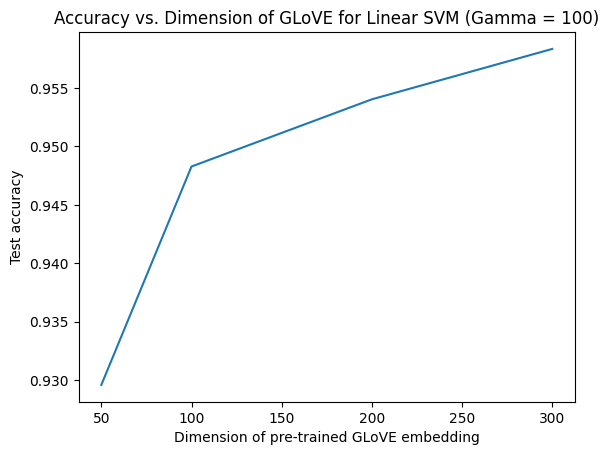

In [ ]:
#Plotting a graph for the accuracy for differenet dimensions of GLoVE embeddings
dim_list = [50,100,200,300]
plt.plot(dim_list,accu_list_glove)
plt.title('Accuracy vs. Dimension of GLoVE for Linear SVM (Gamma = 100)')
plt.xlabel('Dimension of pre-trained GLoVE embedding')
plt.ylabel('Test accuracy')
plt.show()

QUESTION 12:

Plot the relationship between the dimension of the pre-trained GLoVE embedding
and the resulting accuracy of the model in the classification task. Describe the observed trend. Is this trend expected? Why or why not? In this part use the different sets of GLoVE vectors from the link.

> The figure above shows the graph between the dimensions of pretrained GLoVE embeddings and the test accuracy. The trend that can be observed is that as the dimensions increase, the accuracy on the test data increases. More dimensions mean that there are more semantics  and more information. Hence a better relation between target words and context words can be found. There we have better feature dependencies and hence more accuracy.  


# **Question 13**

In [ ]:
#Creating reduced dimensions
reduced_dim_embedding = umap_.UMAP(n_components=2, metric='euclidean').fit(X_train_fit)
print(reduced_dim_embedding.embedding_.shape)

(2780, 2)


In [ ]:
YtrainTextLabel = []
for label in y_train:
    if(label==0):
        YtrainTextLabel.append('Sports')
    else:
        YtrainTextLabel.append('Climate')

random = np.random.normal(0, 1, [4732,300])
random = random / np.linalg.norm(random)
reduced_dim_s = umap_.UMAP(n_components=2, metric='cosine').fit(random)

/usr/local/lib/python3.10/dist-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


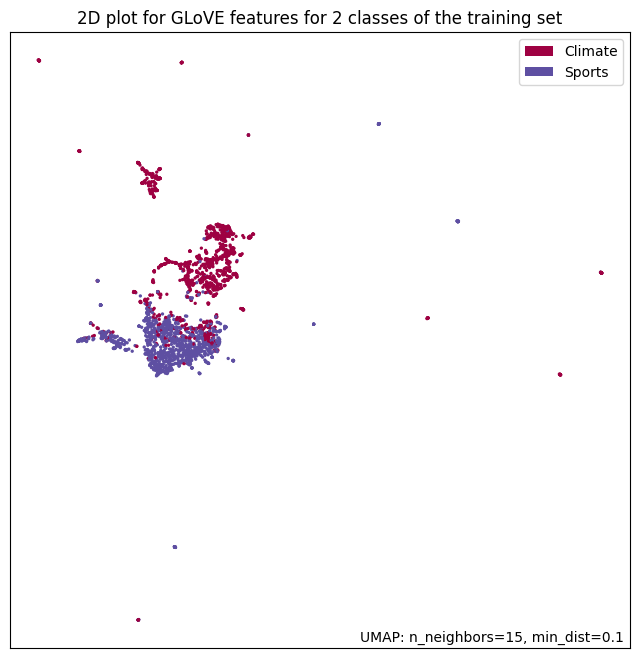

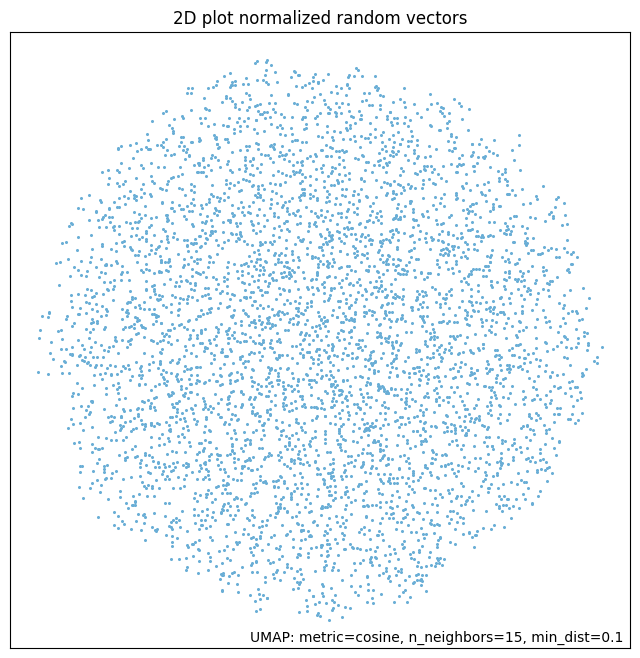

In [ ]:
glove_plot = umap.plot.points(reduced_dim_embedding, labels=np.array(YtrainTextLabel))
plt.title('2D plot for GLoVE features for 2 classes of the training set')

random_plot = umap.plot.points(reduced_dim_s)
plt.title('2D plot normalized random vectors')
plt.show()

QUESTION 13:

Compare and contrast the two visualizations. Are there clusters formed in either or both of the plots? We will pursue the clustering aspect further in the next project.

> We can observe that for the GLoVE model, distinct clusters are formed. Whereas for the random vectors, we cannot see separate clusters. Instead, we can observe one big cluster. This proves that GLoVE is able to accurately distinguish between the two dataset features i.e climate and sports. This shows successful learning of the classifier and that all the points are evenly distributed.


